# Master Thesis Script
## Descriptive Statistics of variables in final dataset

Tasks in this script:
- Analyse tweeting and retweeting across parties
- Analyse LEIA emotion labels and sentiment labels
- DW-NOMINATE score
- NewsGuard score
- In- and out-group words
- Politician characteristics, incl. Chamber, State
- Some variable correlations
- With author's manual emotion and sentiment annotations, compute LEIA F1 score and use ROC curve to identify best threshold for continuous neutrality label

In [9]:
!pip install fitter

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import regex as re
import json
import matplotlib.pyplot as plt
import scipy
import statistics
import math
import random
import scipy.stats as stats
from sklearn.metrics import f1_score
from fitter import Fitter, get_common_distributions, get_distributions
import random

In [52]:
# share of democrat vs republican tweets
data['Party'].value_counts()

Democrat      315887
Republican    225613
Name: Party, dtype: int64

In [63]:
print("Share of Tweets by Democrats: " + str(round(315887/len(data),2)))
print("Share of Tweets by Republicans: " + str(round(225613/len(data),2)))

Share of Tweets by Democrats: 0.58
Share of Tweets by Republicans: 0.42


We have 58% of Tweets from Democrats and 42% of Tweets from Republicans. 

<AxesSubplot:ylabel='Frequency'>

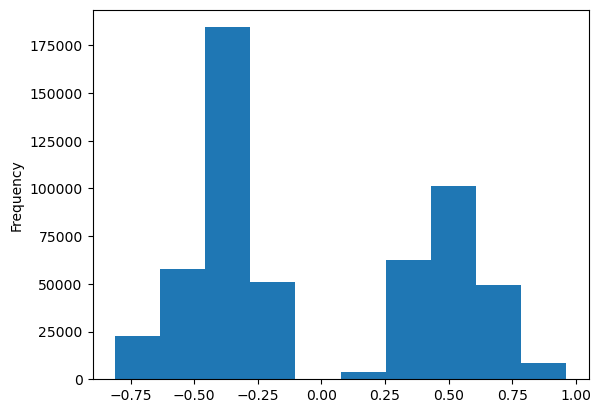

In [41]:
# distribution of DW-nominate score
#print(type(data["nominate_dim1"][0]))
data["nominate_dim1"].plot.hist()

In [ ]:
# negative numbers are Democrats, positive Republicans

In [103]:
f = open(r'C:\Users\Simmendinger\OneDrive - bwedu\Dokumente\Konstanz SEDS Data\4. Semester\Master Thesis\Data\Merged_Data_20230501_2.json')
  
# returns JSON object as 
# a dictionary
data_w_retweets = pd.read_json(f)
  
# Closing file
f.close()

In [104]:
data_rt_only = data_w_retweets[(data_w_retweets['referenced_tweets.retweeted.id'] != "None")]

In [105]:
print(len(data_rt_only))

162536


In [106]:
data_rt_only2 = data_rt_only.rename(columns={"Member_Name_y": "Congress_Member_Name"})

In [107]:
data_rt_only2["Number_Liberal_Words"] = np.nan
data_rt_only2["Number_Conservative_Words"] = np.nan
data_rt_only2["Anger"] = np.nan
data_rt_only2["Happiness"] = np.nan
data_rt_only2["Fear"] = np.nan
data_rt_only2["Affection"] = np.nan
data_rt_only2["Sadness"] = np.nan
data_rt_only2["Positive_Sentiment"] = np.nan
data_rt_only2["Negative_Sentiment"] = np.nan
data_rt_only2["Number_Outgroup_Words"] = np.nan
data_rt_only2["Number_Ingroup_Words"] = np.nan
data_rt_only2["number_retweets"] = np.nan

In [108]:
data_rt_only2["Neutral_Sentiment"] = np.nan

In [109]:
data_rt_only2 = data_rt_only2[['id', 'author_id', 'created_at', 'referenced_tweets.retweeted.id',
       'retweeted_user_id', 'text', 'lang', 'source',
       'public_metrics.retweet_count', 'public_metrics.quote_count',
       'public_metrics.reply_count', 'entities.hashtags', 'entities.urls',
       'author.username', 'author.name',
       'author.public_metrics.followers_count',
       'author.public_metrics.following_count',
       'author.public_metrics.tweet_count', 'retweeted', 'author_name',
        'Twitter_author_name', 
        'chamber',  'state_abbrev', 'bioname',
       'nominate_dim1', 'nominate_dim2', 'nominate_geo_mean_probability',
       'Congress', 'Party', 'Congress_Member_Name', 
       'Retweeted_author_party', 'Retweeted_author_nominate_dim1',
       'Democrat_retweets', 'Republican_retweets', 'url', 'expanded_url',
       'text_clean', 'fixed_urls_final2', 'matched_NG_domain_new', 'matched_Ind_domain_new',
       'NG_score', 'NG_rating', 'Ind_acc', 'Ind_transp', 'Ind_type']]

In [110]:
data_full = data.append(data_rt_only2)

C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_19980\2411434900.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_full = data.append(data_rt_only2)


In [111]:
print(len(data), len(data_full))

541500 704036


In [258]:
Dem_rts = data_rt_only2.Democrat_retweets.values.tolist()
Rep_rts = data_rt_only2.Republican_retweets.values.tolist()

(array([91450.,  5890.,   611.,     0.,   245.,  4066.,     0.,     0.,
            0.,   255.]),
 array([  0. ,  11.7,  23.4,  35.1,  46.8,  58.5,  70.2,  81.9,  93.6,
        105.3, 117. ]),
 <BarContainer object of 10 artists>)

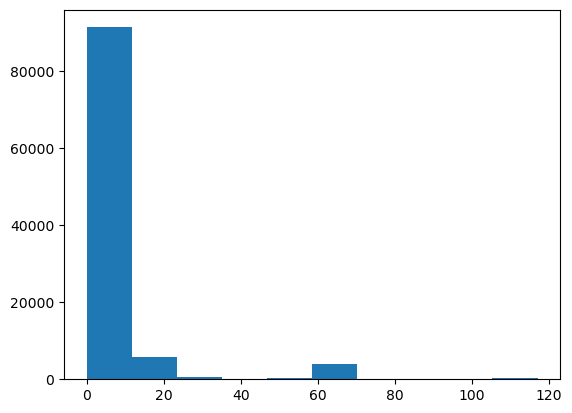

In [261]:
plt.hist(Rep_rts)

In [3]:
print(len(data))

541500


In [114]:
data_authors = data_full[["author_id", "author.username", "author.name", "retweeted_user_id"]]

In [115]:
data_authors

,author_id,author.username,author.name,retweeted_user_id
0,211530910,RepBillJohnson,Rep. Bill Johnson,None
1,211530910,RepBillJohnson,Rep. Bill Johnson,None
2,211530910,RepBillJohnson,Rep. Bill Johnson,None
3,211530910,RepBillJohnson,Rep. Bill Johnson,None
4,211530910,RepBillJohnson,Rep. Bill Johnson,None
...,...,...,...,...
1416815,210926192,RepCuellar,Rep. Henry Cuellar,1392322945.0
1416820,210926192,RepCuellar,Rep. Henry Cuellar,1392322945.0
1416824,210926192,RepCuellar,Rep. Henry Cuellar,1392322945.0
1416828,210926192,RepCuellar,Rep. Henry Cuellar,1392322945.0


In [14]:
df_authors = data_authors.drop_duplicates()

In [15]:
df_authors

,author_id,author.username,author.name
0,211530910,RepBillJohnson,Rep. Bill Johnson
745,81207735,JohnsonLeads,Bill Johnson
816,219429281,RepKinzinger,Adam Kinzinger
1852,231510077,JoaquinCastrotx,Joaquin Castro
2973,233693291,RepRickCrawford,Rep. Rick Crawford
...,...,...,...
537701,163570705,repcleaver,Rep. Emanuel Cleaver
539426,168502762,RepEBJ,Rep. Eddie Bernice Johnson
540151,188403766,Foster4Congress,Bill Foster
540349,193732179,RepJudyChu,Judy Chu


In [19]:
# load the original dataset with 9 mil observations
data_long = pd.read_csv(r'C:\Users\Simmendinger\Downloads\file.txt', dtype={"id":str, "author_id":str}, header = None)


C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_19980\2879627792.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,12,13,14,15,16,18,19,20,21,23,27,30,31,32,33,34,35,36,41,42,43,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,73,74,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  data_long = pd.read_csv(r'C:\Users\Simmendinger\Downloads\file.txt', dtype={"id":str, "author_id":str}, header = None)


In [147]:
#data_rt_only_long = data_long[(data_long['referenced_tweets.retweeted.id'] != "None")]
data_rt_only_long = data_long[~(data_long['referenced_tweets.replied_to.id'].isna())]

In [148]:
print(len(data_rt_only_long))

581194


In [145]:
print(len(data_long))

5952762


In [22]:
data_long.columns = data_long.iloc[0]

In [26]:
data_long_2 = data_long.drop_duplicates(subset=['author_id'])

In [27]:
print(len(data_long_2))

1119


In [122]:
data_long_2["author_username"] = data_long_2["author.username"]
data_authors["author_username"] = data_authors["author.username"]

C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_19980\2416588485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_long_2["author_username"] = data_long_2["author.username"]
C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_19980\2416588485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_authors["author_username"] = data_authors["author.username"]


In [123]:
data_long_ids = data_long_2.author_id.values.tolist()

In [124]:
df_author_old = data_authors.author_username.values.tolist()
df_author_new = data_long_2.author_username.values.tolist()
df_id_new = data_long_2.author_id.values.tolist()

In [134]:
df_id_old = data_authors.author_id.values.tolist()

In [126]:
id_fixed = []
for author_old in df_author_old:
    for author_new, id_new in zip(df_author_new, df_id_new):
        if author_old == author_new:
            id_fixed.append(id_new)
            break
            


In [130]:
print(len(id_fixed), len(data_authors))

704036 704036


In [131]:
for id_old, id_fixed_new in zip(df_id_old[150000:150500], id_fixed[150000:150500]):
    print(id_old)
    print(id_fixed_new)
    print("next")

183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
183062944
183062944
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199839
next
1099199839
1099199

In [132]:
data_authors["author_id_new"] = id_fixed

C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_19980\2311728093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_authors["author_id_new"] = id_fixed


In [135]:
retweeted_user_id_lst_old = data_authors.retweeted_user_id.values.tolist()
#id_fixed
#df_id_old

In [136]:
print(len(id_fixed), len(df_id_old), len(retweeted_user_id_lst_old))

704036 704036 704036


In [137]:
id_fixed_nodup = list(dict.fromkeys(id_fixed))
df_id_old_nodup = list(dict.fromkeys(df_id_old))

In [138]:
print(len(id_fixed_nodup), len(df_id_old_nodup))

907 907


In [170]:
retweeted_id_new_lst = []
count = 0
for retweeted_id in retweeted_user_id_lst_old:
    match = False
    if retweeted_id == "None":
        retweeted_id_new_lst.append("None")
    else:
        for id_old, id_new in zip(df_id_old_nodup, id_fixed_nodup):
            if retweeted_id == id_old:
                id_old_int = int(id_old)
                
                id_strng = str(id_old_int)
                #print(id_strng)
                retweeted_id_new_lst.append(id_strng)
                match = True
        if match == False:
            count+=1
            retweeted_id_new_lst.append(retweeted_id)
            
print(count)

146306


In [163]:
print(len(retweeted_id_new_lst), len(retweeted_user_id_lst_old))

704036 704036


In [171]:
data_full["author_id_new"] = id_fixed
data_full["retweeted_user_id_new"] = retweeted_id_new_lst

In [172]:
data_full

,id,author_id,created_at,referenced_tweets.retweeted.id,retweeted_user_id,text,lang,source,public_metrics.retweet_count,public_metrics.quote_count,...,Fear,Affection,Sadness,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment,Number_Outgroup_Words,Number_Ingroup_Words,author_id_new,retweeted_user_id_new
0,1621230645610414080,211530910,2023-02-02 19:34:41,None,None,"Today, I introduced the JOBS Act with @RepLBR,...",en,None,2,1,...,0.100830,0.301008,0.034914,0.580993,0.413207,0.005800,0.0,0.0,211530910,None
1,1619006992689004544,211530910,2023-01-27 16:18:41,None,None,Proud to announce that local high school stude...,en,None,0,0,...,0.029285,0.111002,0.035303,0.970873,0.027764,0.001363,0.0,0.0,211530910,None
2,1618731454506369024,211530910,2023-01-26 22:03:47,None,None,Rural communities across the country are dedic...,en,None,1,0,...,0.163653,0.060004,0.058145,0.053434,0.498207,0.448359,1.0,0.0,211530910,None
3,1616520819672334336,211530910,2023-01-20 19:39:31,None,None,"Yesterday, I met with the Mahoning Valley Path...",en,None,1,0,...,0.051474,0.655669,0.033115,0.383426,0.607233,0.009341,0.0,0.0,211530910,None
4,1611776007500881920,211530910,2023-01-07 17:25:20,None,None,I’m extremely honored and humbled to have been...,en,None,1,0,...,0.044239,0.472845,0.034120,0.981596,0.015679,0.002725,0.0,2.0,211530910,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416815,330751695355260928,210926192,2013-05-04 18:32:03,330751577900000000.0,1392322945.0,via @monitornews “Feds may acquire more land f...,en,None,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0
1416820,330443359166529536,210926192,2013-05-03 22:06:50,330443169300000000.0,1392322945.0,via @TxPotomac #TexMessage: After FAA furlough...,en,None,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0
1416824,330352349505785856,210926192,2013-05-03 16:05:12,330331450500000000.0,1392322945.0,VIDEO: via @KVEO @RepCuellar Congressman Cuell...,en,None,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0
1416828,329430724732129280,210926192,2013-05-01 03:03:00,329430614700000000.0,1392322945.0,.@elpasotimes Congressmen @RepBetoORourke &amp...,en,None,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0


In [174]:
data_full.reset_index(inplace = True)

In [175]:
data_full

,index,id,author_id,created_at,referenced_tweets.retweeted.id,retweeted_user_id,text,lang,source,public_metrics.retweet_count,...,Fear,Affection,Sadness,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment,Number_Outgroup_Words,Number_Ingroup_Words,author_id_new,retweeted_user_id_new
0,0,1621230645610414080,211530910,2023-02-02 19:34:41,None,None,"Today, I introduced the JOBS Act with @RepLBR,...",en,None,2,...,0.100830,0.301008,0.034914,0.580993,0.413207,0.005800,0.0,0.0,211530910,None
1,1,1619006992689004544,211530910,2023-01-27 16:18:41,None,None,Proud to announce that local high school stude...,en,None,0,...,0.029285,0.111002,0.035303,0.970873,0.027764,0.001363,0.0,0.0,211530910,None
2,2,1618731454506369024,211530910,2023-01-26 22:03:47,None,None,Rural communities across the country are dedic...,en,None,1,...,0.163653,0.060004,0.058145,0.053434,0.498207,0.448359,1.0,0.0,211530910,None
3,3,1616520819672334336,211530910,2023-01-20 19:39:31,None,None,"Yesterday, I met with the Mahoning Valley Path...",en,None,1,...,0.051474,0.655669,0.033115,0.383426,0.607233,0.009341,0.0,0.0,211530910,None
4,4,1611776007500881920,211530910,2023-01-07 17:25:20,None,None,I’m extremely honored and humbled to have been...,en,None,1,...,0.044239,0.472845,0.034120,0.981596,0.015679,0.002725,0.0,2.0,211530910,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704031,1416815,330751695355260928,210926192,2013-05-04 18:32:03,330751577900000000.0,1392322945.0,via @monitornews “Feds may acquire more land f...,en,None,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0
704032,1416820,330443359166529536,210926192,2013-05-03 22:06:50,330443169300000000.0,1392322945.0,via @TxPotomac #TexMessage: After FAA furlough...,en,None,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0
704033,1416824,330352349505785856,210926192,2013-05-03 16:05:12,330331450500000000.0,1392322945.0,VIDEO: via @KVEO @RepCuellar Congressman Cuell...,en,None,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0
704034,1416828,329430724732129280,210926192,2013-05-01 03:03:00,329430614700000000.0,1392322945.0,.@elpasotimes Congressmen @RepBetoORourke &amp...,en,None,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0


In [180]:
# although the tweet ids got a bit messed up at times, with the complex numbering,
# the tweet ids in my dataframe are still all unique and this is therefore not problematic

In [181]:
data_full.to_json(r"C:\Users\Simmendinger\OneDrive - bwedu\Dokumente\Konstanz SEDS Data\4. Semester\Master Thesis\Data\Final_Data\Final_Data_20230508.json")

Analysing Dataset

In [4]:
# Opening JSON file
f = open(r'Final_Data_20230508.json')
  
# returns JSON object as 
# a dictionary
data = pd.read_json(f)
  
# Closing file
f.close()

Now analyse the emotion and sentiment variables: 
- check if neutral sentiment and emotion labels are assigned correctly
- take 20 per emotion for high and low scores, and 20 for neutral score and annotate; so overall, annotate 100 tweets and check how many do I agree with

In [38]:
tweet_lst = []
neutral_sent = []
for i in data.index:
    if (data.at[i, 'Negative_Sentiment'] > data.at[i, 'Neutral_Sentiment'] and data.at[i, 'Negative_Sentiment'] > data.at[i, 'Positive_Sentiment']):
        #print(data.at[i, 'Neutral_Sentiment'])
        #print(data.at[i, 'Positive_Sentiment'])
        #print(data.at[i, 'Negative_Sentiment'])
        #print("next")
        help_lst = []
        help_lst.append(data.at[i, 'text'])
        neutral = data.at[i, 'Neutral_Sentiment']
        positive = data.at[i, 'Positive_Sentiment']
        negative = data.at[i, 'Negative_Sentiment']
        mean = (positive+negative)/2
        var = ((positive-mean)**2 + (negative-mean)**2) /2
        help_lst.append(data.at[i, 'Neutral_Sentiment'])
        
        help_lst.append(data.at[i, 'Positive_Sentiment'])
        help_lst.append(data.at[i, 'Negative_Sentiment'])
        help_lst.append(var)
        tweet_lst.append(help_lst)

Analyse Emotion labels now

In [31]:
tweet_lst = []

for i in data.index:
    if (data.at[i, 'Fear'] > data.at[i, 'Affection'] and data.at[i, 'Anger'] > data.at[i, 'Affection'] and data.at[i, 'Sadness'] > data.at[i, 'Affection'] and data.at[i, 'Happiness'] > data.at[i, 'Affection']):
        #print(data.at[i, 'Neutral_Sentiment'])
        #print(data.at[i, 'Positive_Sentiment'])
        #print(data.at[i, 'Negative_Sentiment'])
        #print("next")
        help_lst = []
        help_lst.append(data.at[i, 'text'])
        anger = data.at[i, 'Anger']
        happiness = data.at[i, 'Happiness']
        sadness = data.at[i, 'Sadness']
        fear = data.at[i, 'Fear']
        affection = data.at[i, 'Affection']
        mean = (anger+sadness+fear+affection)/4
        var = ((anger-mean)**2 + (sadness-mean)**2 + (fear-mean)**2 + (affection-mean)**2 )/4
        help_lst.append(data.at[i, 'Affection'])
        help_lst.append(data.at[i, 'Fear'])
        help_lst.append(data.at[i, 'Sadness'])
        help_lst.append(data.at[i, 'Happiness'])
        
        help_lst.append(data.at[i, 'Neutral_Sentiment'])
        
        
        
        help_lst.append(var)
        tweet_lst.append(help_lst)

In [32]:
print(random.sample(tweet_lst, 20))

[["It’s official. @AjitPaiFCC plans to shred the @FCC's 2015 Open Internet Order and destroy #NetNeutrality protection. https://t.co/6N9sZvGqS6", 0.048054215000000004, 0.13106991, 0.056780744, 0.14611359000000002, 0.2167125, 0.0555833083317792], ["I'll be going live on @OPBTOL shortly to talk about the coup on the U.S. Capitol yesterday. Stream online using the link below:\\n\\nhttps://t.co/YBvBxkyiNf", 0.067552544, 0.4188596, 0.10996345, 0.09485096, 0.9352252999999999, 0.020654003302715298], ['Joseph Otting was appointed by @realDonaldTrump to head the @USOCC: the agency responsible for policing discriminatory lending practices. He just gave @citibank a free pass on discriminating against people of color. https://t.co/RXe4e6C8LU', 0.039495856, 0.08614891, 0.06466185, 0.03959965, 0.34009928, 0.0939036803046329], ['Expanding federal powers &amp; constant denial of accountability left @EPAScottPruitt with a full plate. https://t.co/HX5YnCLajF', 0.038800105, 0.4108224, 0.05983529, 0.03932

In [ ]:
# 20 highest anger are correct
# 20 highest happiness correct
# 20 highest fear correct, vast majority is stoking fear
# 20 highest sadness correct
# 20 highest affection correct (relatively neutral, a lot are also highest in neutral sentiment)

In [ ]:
# 20 lowest anger are correct
# 20 lowest happiness correct
# 20 lowest sadness correct
# 20 lowest fear correct
# 20 lowest affection correct

Descriptives

In [33]:
data

,index,id,author_id,created_at,referenced_tweets.retweeted.id,retweeted_user_id,text,lang,source,public_metrics.retweet_count,...,Fear,Affection,Sadness,Positive_Sentiment,Neutral_Sentiment,Negative_Sentiment,Number_Outgroup_Words,Number_Ingroup_Words,author_id_new,retweeted_user_id_new
0,0,1621230645610414080,211530910,2023-02-02 19:34:41,None,None,"Today, I introduced the JOBS Act with @RepLBR,...",en,None,2,...,0.100830,0.301008,0.034914,0.580993,0.413207,0.005800,0.0,0.0,211530910,None
1,1,1619006992689004544,211530910,2023-01-27 16:18:41,None,None,Proud to announce that local high school stude...,en,None,0,...,0.029285,0.111002,0.035303,0.970873,0.027764,0.001363,0.0,0.0,211530910,None
2,2,1618731454506369024,211530910,2023-01-26 22:03:47,None,None,Rural communities across the country are dedic...,en,None,1,...,0.163653,0.060004,0.058145,0.053434,0.498207,0.448359,1.0,0.0,211530910,None
3,3,1616520819672334336,211530910,2023-01-20 19:39:31,None,None,"Yesterday, I met with the Mahoning Valley Path...",en,None,1,...,0.051474,0.655669,0.033115,0.383426,0.607233,0.009341,0.0,0.0,211530910,None
4,4,1611776007500881920,211530910,2023-01-07 17:25:20,None,None,I’m extremely honored and humbled to have been...,en,None,1,...,0.044239,0.472845,0.034120,0.981596,0.015679,0.002725,0.0,2.0,211530910,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704031,1416815,330751695355260928,210926192,2013-05-04 18:32:03,330751577900000000.0,1392322945.0,via @monitornews “Feds may acquire more land f...,en,None,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0
704032,1416820,330443359166529536,210926192,2013-05-03 22:06:50,330443169300000000.0,1392322945.0,via @TxPotomac #TexMessage: After FAA furlough...,en,None,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0
704033,1416824,330352349505785856,210926192,2013-05-03 16:05:12,330331450500000000.0,1392322945.0,VIDEO: via @KVEO @RepCuellar Congressman Cuell...,en,None,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0
704034,1416828,329430724732129280,210926192,2013-05-01 03:03:00,329430614700000000.0,1392322945.0,.@elpasotimes Congressmen @RepBetoORourke &amp...,en,None,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210926192,1392322945.0


In [36]:
count = 0
for i in data.index:
    if data.at[i, 'retweeted_user_id'] != "None":
        #print(data.at[i, 'Neutral_Sentiment'])
        count+=1
        
print(count)

162536


In [5]:
# only use dataframe with original tweets

data_OG = data[data["retweeted_user_id"] == "None"]

In [8]:
count = 0
for i in data_OG.index:
    if data_OG.at[i, 'lang'] != "en":
        #print(data.at[i, 'lang'])
        #print(data.at[i, 'text'])
        count+=1
        
        
print(count)

6826


In [7]:
print(len(data_OG))

541500


Number of retweets

In [25]:
data_OG.loc[:, 'public_metrics.retweet_count'].mean()
data_OG.loc[:, 'public_metrics.retweet_count'].std()

539.0026575720525

Number of followers

In [24]:
data_OG.loc[:, 'author.public_metrics.followers_count'].mean()
data_OG.loc[:, 'author.public_metrics.followers_count'].std()

1930031.2915169385

In [23]:
data_OG.loc[:, 'author.public_metrics.followers_count'].min()
data_OG.loc[:, 'author.public_metrics.followers_count'].max()

20049268

C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_2824\2394086403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OG['log_followers'] = np.log10(data_OG['author.public_metrics.followers_count'])


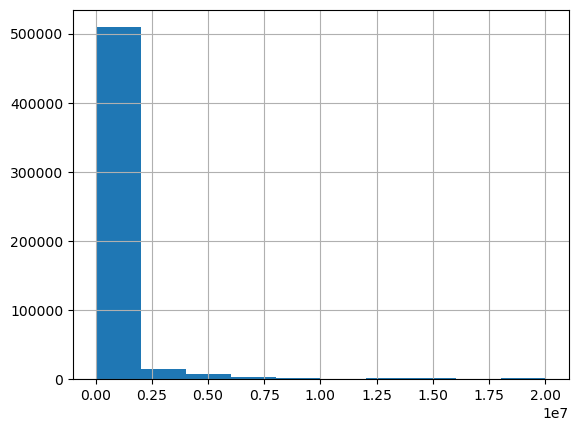

In [28]:
data_OG.loc[:, 'author.public_metrics.followers_count'].hist()
data_OG['log_followers'] = np.log10(data_OG['author.public_metrics.followers_count'])
#data_OG.loc[:, 'log_followers'].hist()

DW-Nominate Score: Dimension 1

In [29]:
data_OG.loc[:, 'nominate_dim1'].mean()

-0.02307930193905016

In [30]:
data_OG.loc[:, 'nominate_dim1'].std()

0.46595473660238995

In [31]:
data_OG.loc[:, 'nominate_dim1'].min()

-0.811

In [32]:
data_OG.loc[:, 'nominate_dim1'].max()

0.961

<AxesSubplot:>

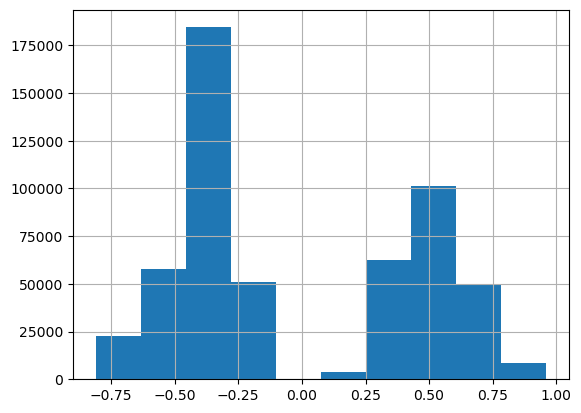

In [33]:
data_OG.loc[:, 'nominate_dim1'].hist()

NewsGuard Score

In [79]:
NG_score_lst = data_OG.NG_score.values.tolist()
NG_rate_lst = data_OG.NG_rating.values.tolist()
Ind_score_lst = data_OG.Ind_acc.values.tolist()
Ind_score_transp_lst = data_OG.Ind_transp.values.tolist()
Ind_score_type_lst = data_OG.Ind_type.values.tolist()

In [80]:
NG_score_lst = [item for item in NG_score_lst if (item != "none" and item != None)]
NG_rate_lst = [item for item in NG_rate_lst if (item != "none" and item != None)]
Ind_score_lst = [item for item in Ind_score_lst if (item != "none" and item != None)]
Ind_score_transp_lst = [item for item in Ind_score_transp_lst if (item != "none" and item != None)]
Ind_score_type_lst = [item for item in Ind_score_type_lst if (item != "none" and item != None)]

In [50]:
print(len(NG_score_lst))

447325


In [49]:
print(sum(NG_score_lst)/len(NG_score_lst))

92.21956072207009


In [52]:
statistics.stdev(NG_score_lst)

12.527795088655385

In [54]:
max(NG_score_lst)

100.0

(array([3.77000e+02, 2.14600e+03, 2.38000e+02, 6.79000e+02, 3.68600e+03,
        3.31300e+03, 3.38460e+04, 6.53700e+03, 5.86810e+04, 3.37822e+05]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

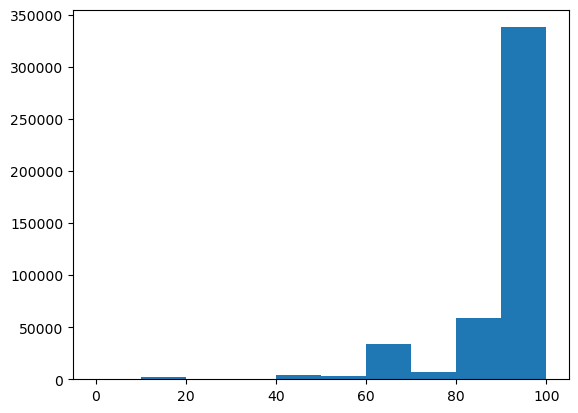

In [59]:
plt.hist(NG_score_lst)

In [81]:
print(len(NG_rate_lst))

456527


In [343]:
NG_score_df = data_OG[(data_OG['NG_score']!= "None") & (data_OG['NG_score']!= "none") & (data_OG['NG_score']!= None)]
NG_score_lst_dem = NG_score_df[(NG_score_df['Party']=="Democrat") ]['NG_score'].values.tolist()
NG_score_lst_rep = NG_score_df[(NG_score_df['Party']=="Republican") ]['NG_score'].values.tolist()
NG_score_lst_dem = [item for item in NG_score_lst_dem if item != None]
NG_score_lst_rep = [item for item in NG_score_lst_rep if item != None]

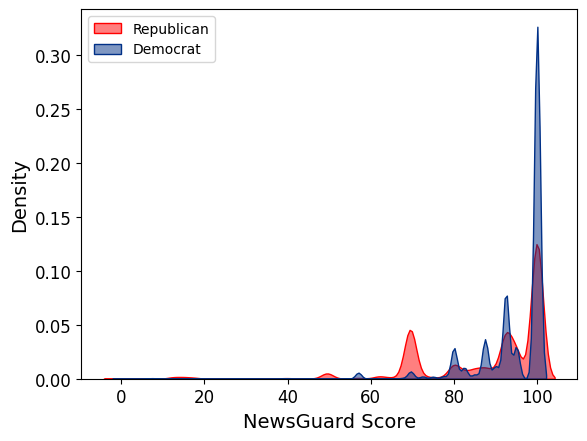

In [378]:
sns.kdeplot(NG_score_lst_rep, fill=True, color='red', alpha=0.5, label = "Republican")
sns.kdeplot(NG_score_lst_dem, fill=True, color="#003087", alpha=0.5, label = "Democrat")
# Set x-axis label with increased font size
plt.xlabel('NewsGuard Score', fontsize=14)

# Set y-axis label with increased font size
plt.ylabel('Density', fontsize=14)

# Set tick labels font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left')
plt.savefig('ABM_Files/Final_Model_Code_Data/Figures/descriptives_NG_RTcount_party.svg', format='svg')
# Display the plot
plt.show()

In [88]:
NG_rate_lst.count("T")
NG_rate_lst.count("N")
NG_rate_lst.count("P")

8882

Independent Score

In [68]:
print(len(Ind_score_lst))
print(len(Ind_score_transp_lst))

463335
463335


In [69]:
print(sum(Ind_score_lst)/len(Ind_score_lst))
print(sum(Ind_score_transp_lst)/len(Ind_score_transp_lst))

4.061514886637099
2.7917683749339033


In [70]:
statistics.stdev(Ind_score_lst)
statistics.stdev(Ind_score_transp_lst)

0.4749429065305047

In [74]:
#max(Ind_score_lst)
#min(Ind_score_lst)

#max(Ind_score_transp_lst)
min(Ind_score_transp_lst)

1

(array([ 14039.,      0.,   3106.,      0.,      0.,  65274.,      0.,
        238811.,      0., 142105.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

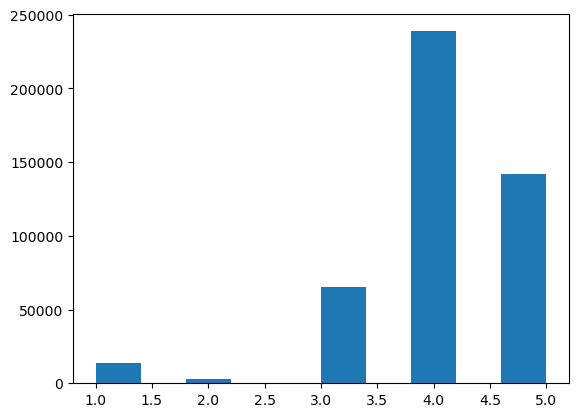

In [76]:
plt.hist(Ind_score_lst)

(array([ 14062.,      0.,      0.,      0.,      0.,  68357.,      0.,
             0.,      0., 380916.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

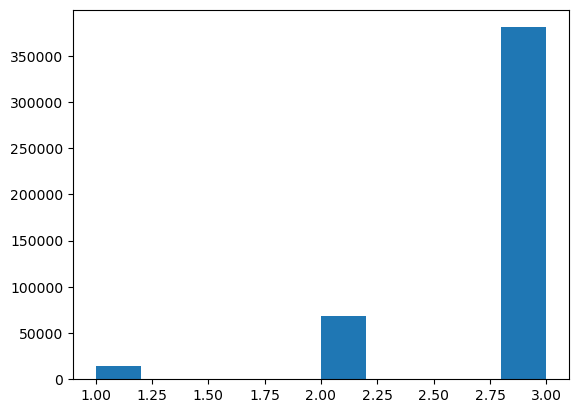

In [77]:
plt.hist(Ind_score_transp_lst)

(array([449273.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  14062.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

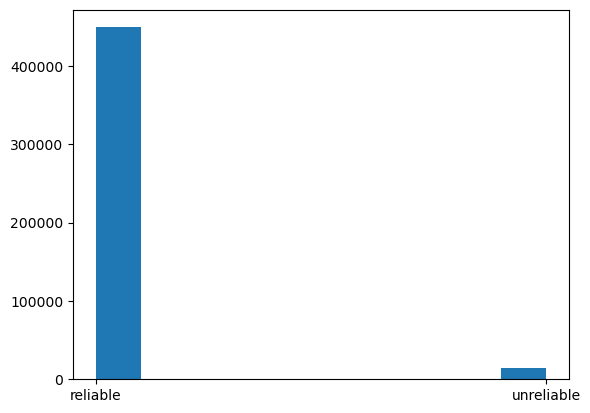

In [91]:
plt.hist(Ind_score_type_lst)

In [93]:
print(len(Ind_score_type_lst))

463335


In [94]:
Ind_score_type_lst.count("reliable")
Ind_score_type_lst.count("unreliable")

14062

Emotions LEIA: Anger

In [95]:
data_OG.loc[:, 'Anger'].mean()

0.2817097170379422

In [96]:
data_OG.loc[:, 'Anger'].std()

0.2518365227827194

In [97]:
data_OG.loc[:, 'Anger'].min()

0.019586967

In [98]:
data_OG.loc[:, 'Anger'].max()

0.8338023

<AxesSubplot:>

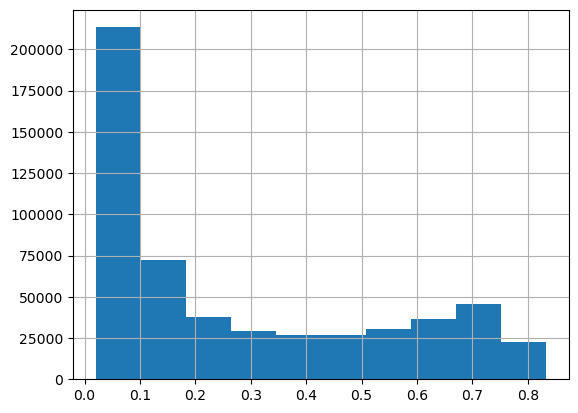

In [99]:
data_OG.loc[:, 'Anger'].hist()

In [101]:
# count number of times where anger is highest among all emotions
count = 0
for i in data_OG.index:
    if (data_OG.at[i, 'Anger'] > data_OG.at[i, 'Affection'] and data_OG.at[i, 'Anger'] > data_OG.at[i, 'Happiness'] and data_OG.at[i, 'Anger'] > data_OG.at[i, 'Sadness'] and data_OG.at[i, 'Anger'] > data_OG.at[i, 'Fear']):
        count+=1

        
print(count)

183249


LEIA Emotion: Happiness

In [102]:
# count number of times where anger is highest among all emotions
count = 0
for i in data_OG.index:
    if (data_OG.at[i, 'Happiness'] > data_OG.at[i, 'Affection'] and data_OG.at[i, 'Happiness'] > data_OG.at[i, 'Anger'] and data_OG.at[i, 'Happiness'] > data_OG.at[i, 'Sadness'] and data_OG.at[i, 'Happiness'] > data_OG.at[i, 'Fear']):
        count+=1

        
print(count)

96448


In [103]:
data_OG.loc[:, 'Happiness'].mean()

0.1813176681662656

In [104]:
data_OG.loc[:, 'Happiness'].std()

0.22261323181576692

In [105]:
data_OG.loc[:, 'Happiness'].min()

0.015938107

In [106]:
data_OG.loc[:, 'Happiness'].max()

0.85440165

<AxesSubplot:>

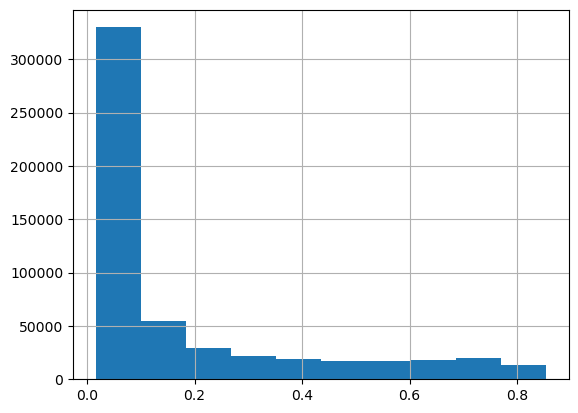

In [107]:
data_OG.loc[:, 'Happiness'].hist()

LEIA Emotion: Fear

In [108]:
# count number of times where anger is highest among all emotions
count = 0
for i in data_OG.index:
    if (data_OG.at[i, 'Fear'] > data_OG.at[i, 'Affection'] and data_OG.at[i, 'Fear'] > data_OG.at[i, 'Anger'] and data_OG.at[i, 'Fear'] > data_OG.at[i, 'Sadness'] and data_OG.at[i, 'Fear'] > data_OG.at[i, 'Happiness']):
        count+=1

        
print(count)

71049


In [109]:
data_OG.loc[:, 'Fear'].mean()

0.1735886028955666

In [110]:
data_OG.loc[:, 'Fear'].std()

0.16523193129001645

In [111]:
data_OG.loc[:, 'Fear'].min()

0.020023916000000003

In [112]:
data_OG.loc[:, 'Fear'].max()

0.8491272

<AxesSubplot:>

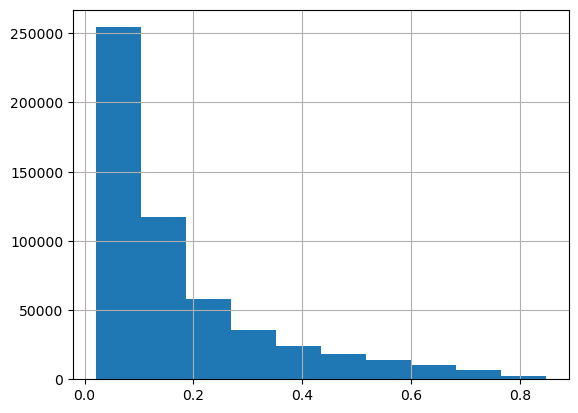

In [113]:
data_OG.loc[:, 'Fear'].hist()

LEIA Emotion: Sadness

In [114]:
# count number of times where anger is highest among all emotions
count = 0
for i in data_OG.index:
    if (data_OG.at[i, 'Sadness'] > data_OG.at[i, 'Affection'] and data_OG.at[i, 'Sadness'] > data_OG.at[i, 'Anger'] and data_OG.at[i, 'Sadness'] > data_OG.at[i, 'Fear'] and data_OG.at[i, 'Sadness'] > data_OG.at[i, 'Happiness']):
        count+=1

        
print(count)

19291


In [115]:
data_OG.loc[:, 'Sadness'].mean()

0.08731249861146276

In [116]:
data_OG.loc[:, 'Sadness'].std()

0.11200618005339025

In [117]:
data_OG.loc[:, 'Sadness'].min()

0.02205769

In [118]:
data_OG.loc[:, 'Sadness'].max()

0.8370133

<AxesSubplot:>

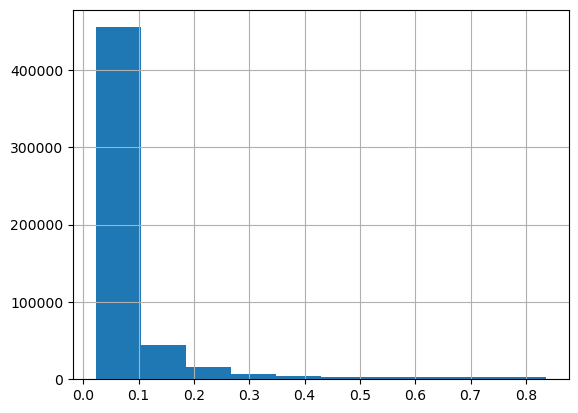

In [119]:
data_OG.loc[:, 'Sadness'].hist()

LEIA Emotion: Affection

In [120]:
# count number of times where anger is highest among all emotions
count = 0
for i in data_OG.index:
    if (data_OG.at[i, 'Affection'] > data_OG.at[i, 'Sadness'] and data_OG.at[i, 'Affection'] > data_OG.at[i, 'Anger'] and data_OG.at[i, 'Affection'] > data_OG.at[i, 'Fear'] and data_OG.at[i, 'Affection'] > data_OG.at[i, 'Happiness']):
        count+=1

        
print(count)

171463


In [121]:
data_OG.loc[:, 'Affection'].mean()

0.2760715091951752

In [122]:
data_OG.loc[:, 'Affection'].std()

0.23149290198448266

In [123]:
data_OG.loc[:, 'Affection'].min()

0.018365448

In [124]:
data_OG.loc[:, 'Affection'].max()

0.838853

<AxesSubplot:>

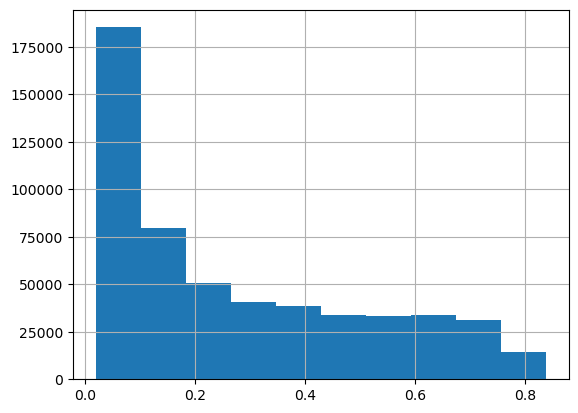

In [132]:
data_OG.loc[:, 'Affection'].hist()

BERT Sentiment

In [126]:
#Neutral Sentiment
count = 0
for i in data_OG.index:
    if (data_OG.at[i, 'Neutral_Sentiment'] > data_OG.at[i, 'Negative_Sentiment'] and data_OG.at[i, 'Neutral_Sentiment'] > data_OG.at[i, 'Positive_Sentiment'] ):
        count+=1

        
print(count)

186913


In [127]:
data_OG.loc[:, 'Neutral_Sentiment'].mean()

0.36241793103585257

In [128]:
data_OG.loc[:, 'Neutral_Sentiment'].std()

0.29431181162121356

In [129]:
data_OG.loc[:, 'Neutral_Sentiment'].min()

0.0052358610000000005

In [130]:
data_OG.loc[:, 'Neutral_Sentiment'].max()

0.97625196

<AxesSubplot:>

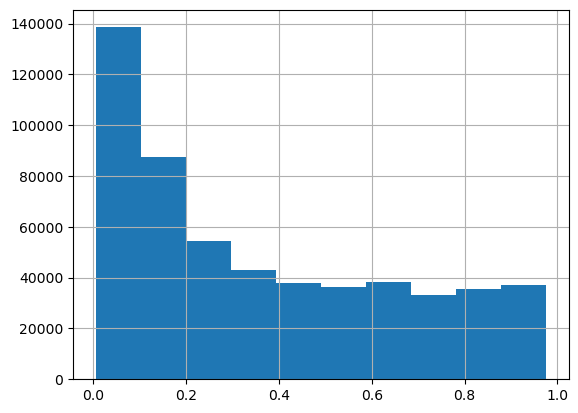

In [131]:
data_OG.loc[:, 'Neutral_Sentiment'].hist()

Negative Sentiment

In [133]:
count = 0
for i in data_OG.index:
    if (data_OG.at[i, 'Negative_Sentiment'] > data_OG.at[i, 'Neutral_Sentiment'] and data_OG.at[i, 'Negative_Sentiment'] > data_OG.at[i, 'Positive_Sentiment'] ):
        count+=1

        
print(count)

172444


In [134]:
data_OG.loc[:, 'Negative_Sentiment'].mean()

0.2927769459867984

In [135]:
data_OG.loc[:, 'Negative_Sentiment'].std()

0.3502549690293405

In [136]:
data_OG.loc[:, 'Negative_Sentiment'].min()

0.0008258371

In [137]:
data_OG.loc[:, 'Negative_Sentiment'].max()

0.96416897

<AxesSubplot:>

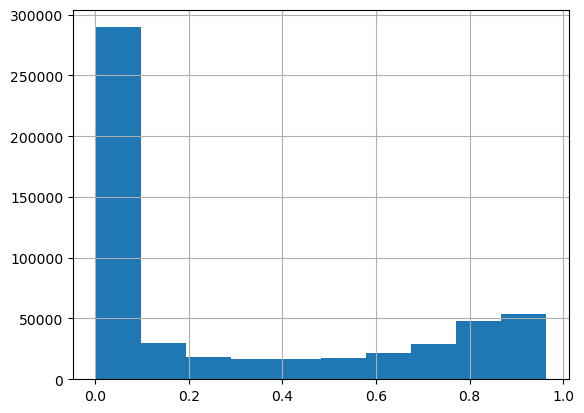

In [138]:
data_OG.loc[:, 'Negative_Sentiment'].hist()

Positive Sentiment

In [139]:
count = 0
for i in data_OG.index:
    if (data_OG.at[i, 'Positive_Sentiment'] > data_OG.at[i, 'Neutral_Sentiment'] and data_OG.at[i, 'Positive_Sentiment'] > data_OG.at[i, 'Negative_Sentiment'] ):
        count+=1

        
print(count)

182143


In [140]:
data_OG.loc[:, 'Positive_Sentiment'].mean()

0.3448051183947901

In [141]:
data_OG.loc[:, 'Positive_Sentiment'].std()

0.3801140842634903

In [142]:
data_OG.loc[:, 'Positive_Sentiment'].min()

0.003429025

In [143]:
data_OG.loc[:, 'Positive_Sentiment'].max()

0.99293715

<AxesSubplot:>

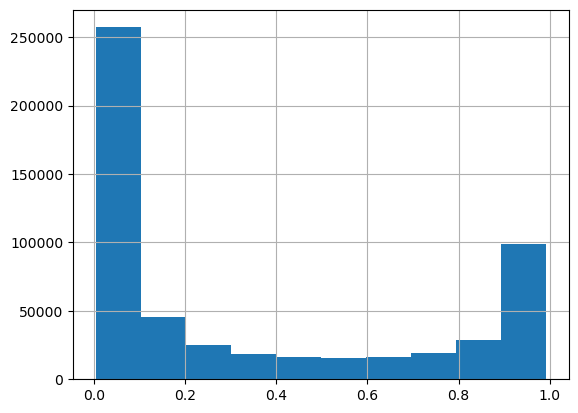

In [144]:
data_OG.loc[:, 'Positive_Sentiment'].hist()

Party

In [165]:
# Democrat
count = 0
for i in data_OG.index:
    if data_OG.at[i, 'Party'] == "Democrat":
        count+=1

        
print(count)

315887


In [167]:
# Republican
count = 0
for i in data_OG.index:
    if data_OG.at[i, 'Party'] == "Republican":
        count+=1

        
print(count)

225613


<AxesSubplot:>

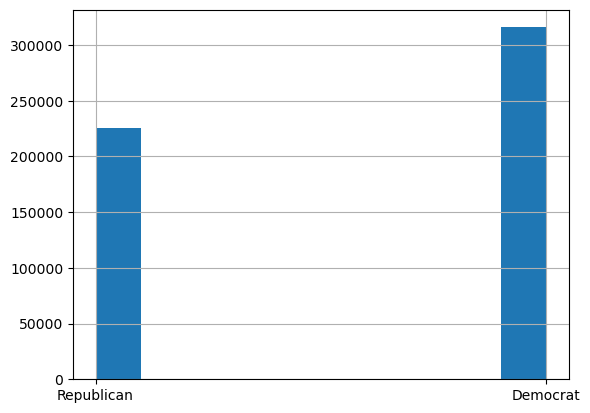

In [168]:
data_OG.loc[:, 'Party'].hist()

Chamber

<AxesSubplot:>

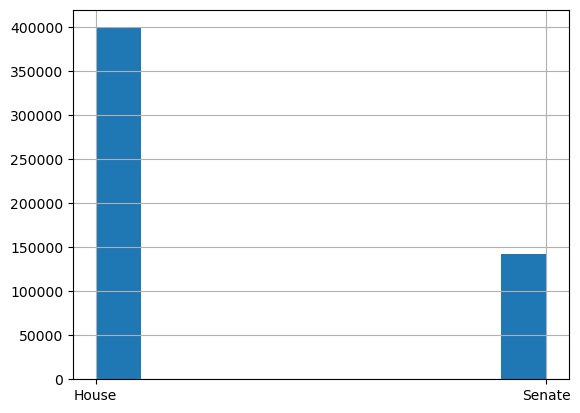

In [170]:
data_OG.loc[:, 'chamber'].hist()

In [172]:
# House
count = 0
for i in data_OG.index:
    if data_OG.at[i, 'chamber'] == "House":
        count+=1

        
print(count)

399363


In [173]:
# Senate
count = 0
for i in data_OG.index:
    if data_OG.at[i, 'chamber'] == "Senate":
        count+=1

        
print(count)

142137


State of Politician

<AxesSubplot:>

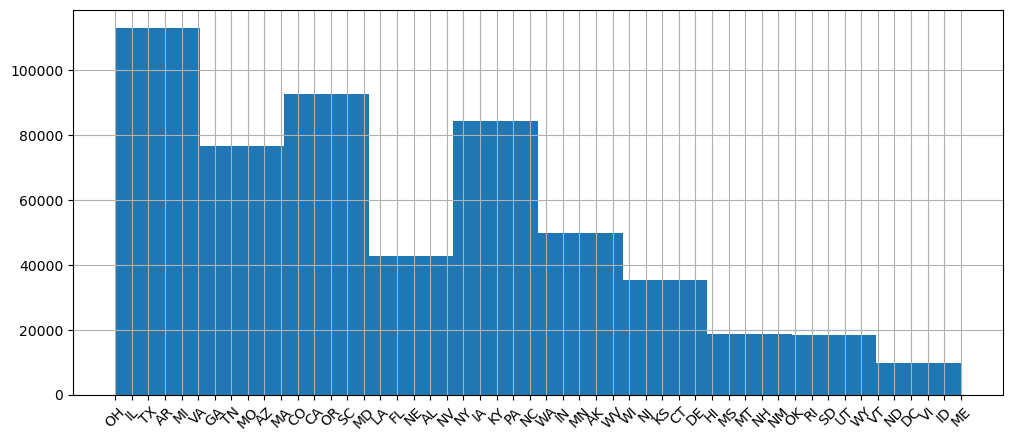

In [181]:
# it's too much detail to check number of tweets per state but we can check if every state is represented/which states
# are not represented

data_OG.loc[:, 'state_abbrev'].hist(xrot = 45, figsize = (12,5))

In [182]:
state_df = data_OG.drop_duplicates(subset='state_abbrev')

In [183]:
print(len(state_df))

52


In [185]:
print(state_df["state_abbrev"])

0         OH
816       IL
1852      TX
2973      AR
3745      MI
5082      VA
5878      GA
6132      TN
6910      MO
7805      AZ
10364     MA
11759     CO
12519     CA
13139     OR
13538     SC
13929     MD
15156     LA
16747     FL
18804     NE
22304     AL
23756     NV
30279     NY
30829     IA
31018     KY
31294     PA
40037     NC
44124     WA
50429     IN
63825     MN
69706     AK
79633     WV
82869     WI
83691     NJ
88680     KS
92534     CT
94787     DE
95227     HI
102234    MS
102543    MT
103638    NH
103849    NM
108057    OK
109235    RI
116946    SD
118450    UT
125622    WY
204055    VT
211138    ND
267230    DC
268133    VI
345078    ID
377825    ME
Name: state_abbrev, dtype: object


In [ ]:
# all states are represented in the Twitter Dataset

Party: by account and politician

In [187]:
# by account
party_acc_df = data_OG.drop_duplicates(subset='author_id_new')

In [195]:
count = 0
for i in party_acc_df.index:
    if party_acc_df.at[i, 'Party'] == "Republican":
        count+=1

        
print(count)

453


<AxesSubplot:>

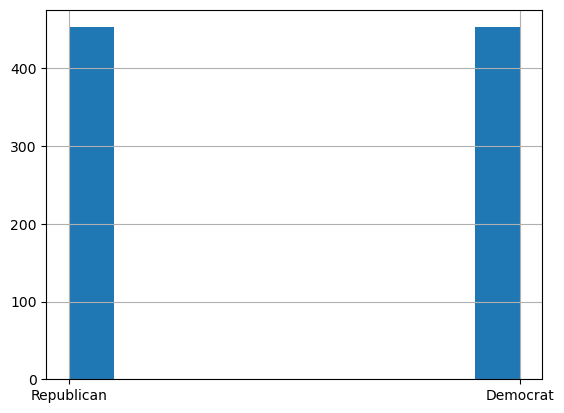

In [191]:
party_acc_df.loc[:, 'Party'].hist()

In [189]:
# by Congress Member
party_CM_df = data_OG.drop_duplicates(subset='Congress_Member_Name')

<AxesSubplot:>

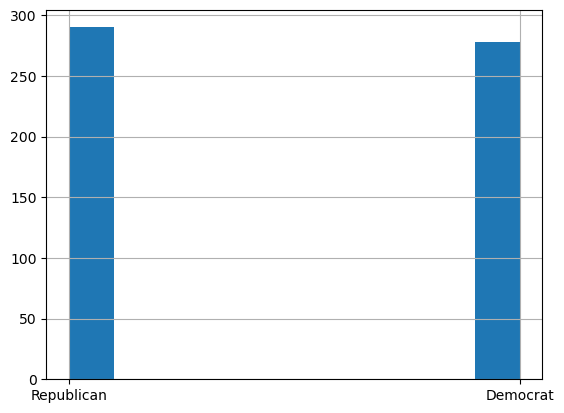

In [192]:
party_CM_df.loc[:, 'Party'].hist()

In [197]:
count = 0
for i in party_CM_df.index:
    if party_CM_df.at[i, 'Party'] == "Democrat":
        count+=1

        
print(count)

278


Outgroup Words

In [200]:
data_OG.loc[:, 'Number_Outgroup_Words'].mean()

0.3051394275161588

In [201]:
data_OG.loc[:, 'Number_Outgroup_Words'].std()

0.6749253267347901

In [202]:
data_OG.loc[:, 'Number_Outgroup_Words'].min()

0.0

In [203]:
data_OG.loc[:, 'Number_Outgroup_Words'].max()

15.0

<AxesSubplot:>

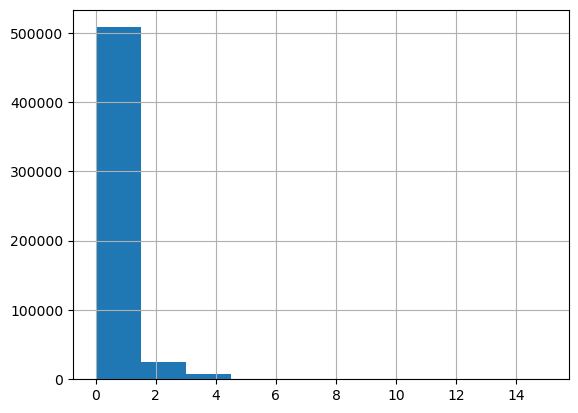

In [199]:
data_OG.loc[:, 'Number_Outgroup_Words'].hist()

Ingroup Words

In [204]:
data_OG.loc[:, 'Number_Ingroup_Words'].mean()

0.2349196675900277

In [208]:
data_OG.loc[:, 'Number_Ingroup_Words'].std()

0.6142017035863907

In [209]:
data_OG.loc[:, 'Number_Ingroup_Words'].min()

0.0

In [210]:
data_OG.loc[:, 'Number_Ingroup_Words'].max()

15.0

<AxesSubplot:>

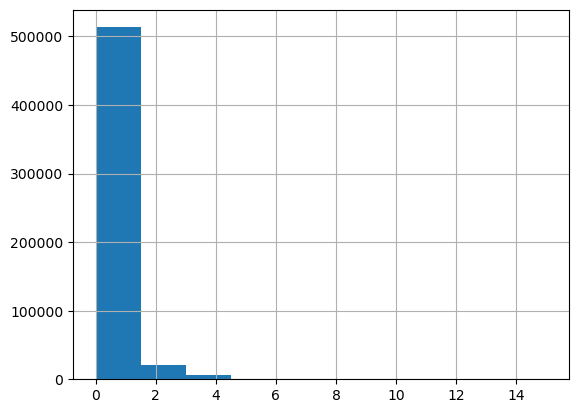

In [212]:
data_OG.loc[:, 'Number_Ingroup_Words'].hist()

In [ ]:
# data is final dataset
# data_OG is final dataset with only original tweets


In [50]:
data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]

C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_9972\38764974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]


Create dataset with retweet observations

In [ ]:
import gzip
import shutil
with gzip.open(r'C:\Users\Simmendinger\Documents\Master Thesis Data/combined_US_politician_twitter_timelines_2010-11-06_to_2023-02-11_esther.csv.gzip', 'rb') as f_in:
    with open('file.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

PermissionError: [Errno 13] Permission denied: 'file.txt'

In [8]:
data_long = pd.read_csv(r'C:\Users\Simmendinger\OneDrive - bwedu\Dokumente\Konstanz SEDS Data\4. Semester\Master Thesis\Code\file.txt', dtype={"id":str, "author_id":str, "retweeted_user_id":str}, header = None)


C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_9972\3647595491.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,12,13,14,15,16,18,19,20,21,23,27,30,31,32,33,34,35,36,41,42,43,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,73,74,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  data_long = pd.read_csv(r'C:\Users\Simmendinger\OneDrive - bwedu\Dokumente\Konstanz SEDS Data\4. Semester\Master Thesis\Code\file.txt', dtype={"id":str, "author_id":str, "retweeted_user_id":str}, header = None)


In [9]:
data_long.columns = data_long.iloc[0]

In [10]:
data_long = data_long.drop(0)

In [12]:
data_OG = data_long[(data_long['referenced_tweets.replied_to.id'].isna()) &  (data_long['referenced_tweets.quoted.id'].isna()) ]

In [19]:
print(len(data_OG))

4841111


In [14]:
data_OG["author_id"] = data_OG["author.id"]

C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_9972\3816651545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OG["author_id"] = data_OG["author.id"]


In [15]:
OG_author_id_lst = data_OG.author_id.values.tolist()
OG_author_id_rt_lst = data_OG.retweeted_user_id.values.tolist()

In [16]:
print(len(OG_author_id_rt_lst))

4841111


In [17]:
df_for_retweets = pd.DataFrame()
df_for_retweets["author_id"] = OG_author_id_lst 
df_for_retweets["rt_author_id"] = OG_author_id_rt_lst
df_for_retweets.to_json("Data_for_retweet_metrics2.json")

In [2]:
# Opening JSON file
f = open(r'C:\Users\Simmendinger\OneDrive - bwedu\Dokumente\Konstanz SEDS Data\4. Semester\Master Thesis\Data\Data_for_retweet\Data_for_retweet_metrics.json')
  
# returns JSON object as 
# a dictionary
data_retweets = pd.read_json(f)
  
# Closing file
f.close()

In [4]:
# Opening JSON file
f = open(r'C:\Users\Simmendinger\OneDrive - bwedu\Dokumente\Konstanz SEDS Data\4. Semester\Master Thesis\Data\To Send\Twitter_authors_Thesis.json')
  
# returns JSON object as 
# a dictionary
data_authors = pd.read_json(f)
  
# Closing file
f.close()

In [6]:
data_authors.dtypes

author_id           int64
author.username    object
author.name        object
author_id_strng     int64
dtype: object

In [7]:
print(len(data_retweets))

4841111


In [255]:
author_id_lst = data.author_id_new.values.tolist()
author_nom_lst = data.nominate_dim1.values.tolist()
author_party_lst = data.Party.values.tolist()
retweeted_author_lst = data_OG.retweeted_user_id_new.values.tolist()

In [ ]:
author_id_lst_nodup = list(dict.fromkeys(author_id_lst))
author_nom_lst_nodup = list(dict.fromkeys(author_nom_lst))
author_party_lst_nodup = list(dict.fromkeys(author_party_lst))

In [ ]:
# now just take the list from data_OG of rt_author_ids and find them in these lists above

In [256]:
retweeted_author_lst2 = []
for item in retweeted_author_lst:
    if item != "None":
        item_fl = float(item)
        item_int = math.trunc(item_fl)
        retweeted_author_lst2.append(item_int)
    else:
        retweeted_author_lst2.append(item)

In [257]:
print(len(retweeted_author_lst2), len(retweeted_author_lst))

704036 704036


In [261]:
author_nom_lst_rt = []
author_party_lst_rt = []
for item in retweeted_author_lst2:
    match = False
    for author, nom_score, party in zip(author_id_lst, author_nom_lst, author_party_lst):
        if item == author:
            author_nom_lst_rt.append(nom_score)
            author_party_lst_rt.append(party)
            match = True
            break
    if match == False:
        author_nom_lst_rt.append(None)
        author_party_lst_rt.append(None)

KeyboardInterrupt: 

Analyse relationship between number of retweets and NewsGuard Score.

In [6]:
data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]

C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_20864\38764974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]


In [8]:
NG_df = data_OG[(data_OG['NG_score'] != "None") & (data_OG['NG_score'] != "none") & (data_OG['NG_score'] != None) & (data_OG['NG_score'].isna() != True)] 
# make deciles of the NG Score
NG_df = NG_df[NG_df["NG_score"] <= 100]


In [8]:
NG_df['NG_score_bins'] = pd.cut(NG_df['NG_score'], 5)

In [9]:
NG_grouped = NG_df.groupby('NG_score_bins', as_index=False)['number_rts'].mean()

In [12]:
NG_grouped = NG_df.groupby('NG_score_bins', as_index=False)['number_rts'].std()

In [10]:
NG_grouped

,NG_score_bins,number_rts
0,"(-0.1, 20.0]",190.047563
1,"(20.0, 40.0]",175.754435
2,"(40.0, 60.0]",161.291618
3,"(60.0, 80.0]",123.028824
4,"(80.0, 100.0]",91.265216


<AxesSubplot:xlabel='NG_score_bins'>

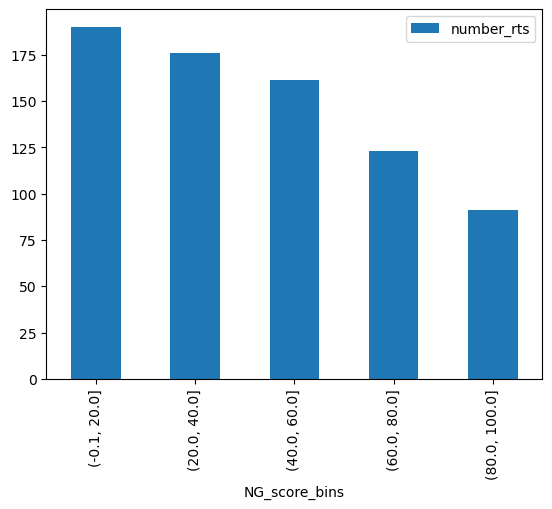

In [11]:
NG_grouped.plot(x="NG_score_bins", y="number_rts", kind="bar")

Now look at this same distribution, but divide number of retweets by politician's number of followers

/tmp/ipykernel_66354/3374733977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]
/tmp/ipykernel_66354/3374733977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NG_df_recent["number_followers"] = NG_df_recent["author.public_metrics.followers_count"]
/tmp/ipykernel_66354/3374733977.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

<AxesSubplot: xlabel='NG_score_bins'>

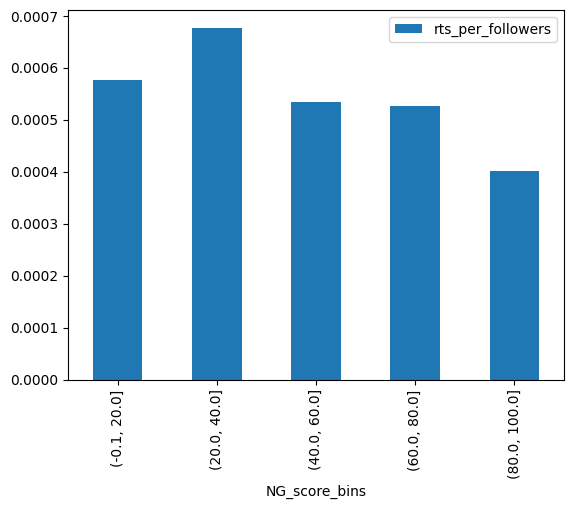

In [9]:
data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]
NG_df = data_OG[(data_OG['NG_score'] != "None") & (data_OG['NG_score'] != "none") & (data_OG['NG_score'] != None) & (data_OG['NG_score'].isna() != True)] 
# make deciles of the NG Score
NG_df = NG_df[NG_df["NG_score"] <= 100]
NG_df["Year"] = NG_df["created_at"].dt.year
# make a df with only observations of 2021-2023
NG_df_recent = NG_df[(NG_df['Year'] >= 2021)] 
NG_df_recent["number_followers"] = NG_df_recent["author.public_metrics.followers_count"]
NG_df_recent["rts_per_followers"] = NG_df_recent["number_rts"] / NG_df_recent["number_followers"]
NG_df_recent['NG_score_bins'] = pd.cut(NG_df_recent['NG_score'], 5)
NG_grouped_recent = NG_df_recent.groupby('NG_score_bins', as_index=False)['rts_per_followers'].mean()
NG_grouped_recent
NG_grouped_recent.plot(x="NG_score_bins", y="rts_per_followers", kind="bar")

#We find that when normalizing the number of retweets per Tweet by the number of followers of the given politician, hereby only looking at years starting in 2021 (as follower number are currently not available historically), there is also a decreasing trend in number of retweets as the NG score increases.

<AxesSubplot:xlabel='NG_score_bins'>

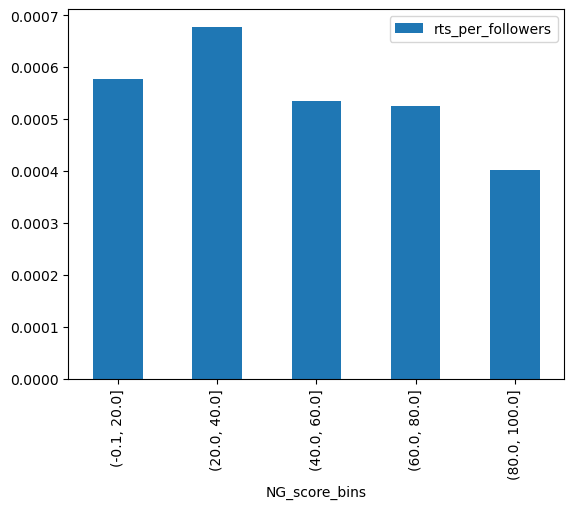

In [30]:
NG_grouped_recent.plot(x="NG_score_bins", y="rts_per_followers", kind="bar")

We find that when normalizing the number of retweets per Tweet by the number of followers of the given politician, hereby only looking at years starting in 2021 (as follower number are currently not available historically), there is also a decreasing trend in number of retweets as the NG score increases.

When looking at the average emotion value per NG Score bin, we can also see that anger has a higher value for lower quality scores, decreasing steadily with each bin. For happiness, we see a similar pattern but somewhat lower in intensity. Affection has the opposite trend, while fear and sadness do not show much of a trend.

In [20]:
# Opening JSON file
f = open(r'C:\Users\Simmendinger\OneDrive - bwedu\Dokumente\Konstanz SEDS Data\4. Semester\Master Thesis\Data\Final_Data\Final_Data_20230508.json')
  
# returns JSON object as 
# a dictionary
data = pd.read_json(f)
  
# Closing file
f.close()


In [21]:
data_OG = data[data["retweeted_user_id"] == "None"]

Analysis based on discussion in meeting on 19/05

In [10]:

data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]
NG_df = data_OG[(data_OG['NG_score'] != "None") & (data_OG['NG_score'] != "none") & (data_OG['NG_score'] != None) & (data_OG['NG_score'].isna() != True)] 
# make deciles of the NG Score
NG_df = NG_df[NG_df["NG_score"] <= 100]
NG_df["Year"] = NG_df["created_at"].dt.year
# make a df with only observations of 2021-2023
NG_df_recent = NG_df[(NG_df['Year'] >= 2021)] 
NG_df_recent["number_followers"] = NG_df_recent["author.public_metrics.followers_count"]
NG_df_recent["rts_per_followers"] = NG_df_recent["number_rts"] / NG_df_recent["number_followers"]
NG_df_recent['NG_score_bins'] = pd.cut(NG_df_recent['NG_score'], 5)
NG_grouped_recent = NG_df_recent.groupby('NG_score_bins', as_index=False)['rts_per_followers'].mean()

/tmp/ipykernel_66354/2575641706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]
/tmp/ipykernel_66354/2575641706.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NG_df_recent["number_followers"] = NG_df_recent["author.public_metrics.followers_count"]
/tmp/ipykernel_66354/2575641706.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [123]:

NG_grouped_recent = NG_df_recent.groupby('NG_score_bins', as_index=False)['number_rts_log'].mean()

In [116]:
NG_grouped_recent

,NG_score_bins,rts_per_followers
0,"(-0.1, 20.0]",1174
1,"(20.0, 40.0]",308
2,"(40.0, 60.0]",2552
3,"(60.0, 80.0]",24566
4,"(80.0, 100.0]",95478


<AxesSubplot: xlabel='NG_score_bins'>

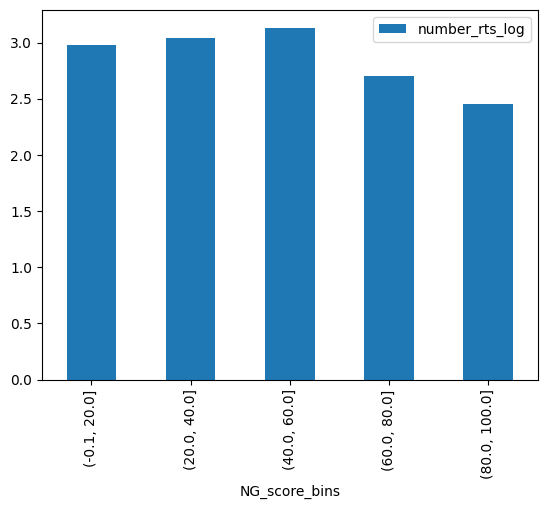

In [124]:
NG_grouped_recent.plot(x="NG_score_bins", y="number_rts_log", kind="bar")

<AxesSubplot:xlabel='NG_score_bins'>

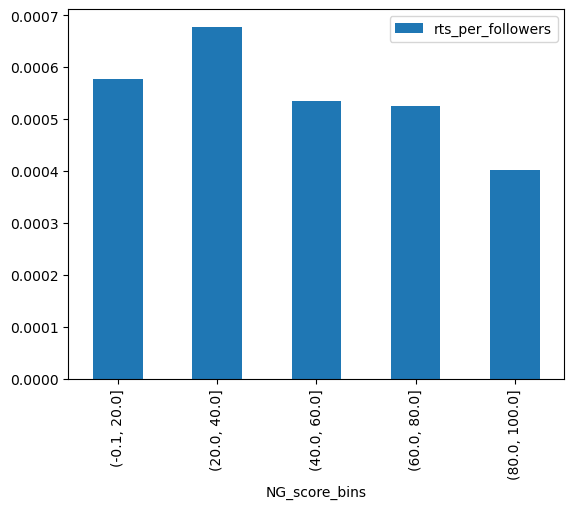

In [24]:
NG_grouped_recent.plot(x="NG_score_bins", y="rts_per_followers", kind="bar")

C:\Users\Simmendinger\AppData\Local\Temp\ipykernel_17476\1230517164.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  NG_df_recent['rts_per_followers'].hist(by=NG_df_recent['NG_score_bins'], ax=ax)


array([[<AxesSubplot:title={'center':'(-0.1, 20.0]'}>,
        <AxesSubplot:title={'center':'(20.0, 40.0]'}>],
       [<AxesSubplot:title={'center':'(40.0, 60.0]'}>,
        <AxesSubplot:title={'center':'(60.0, 80.0]'}>],
       [<AxesSubplot:title={'center':'(80.0, 100.0]'}>, <AxesSubplot:>]],
      dtype=object)

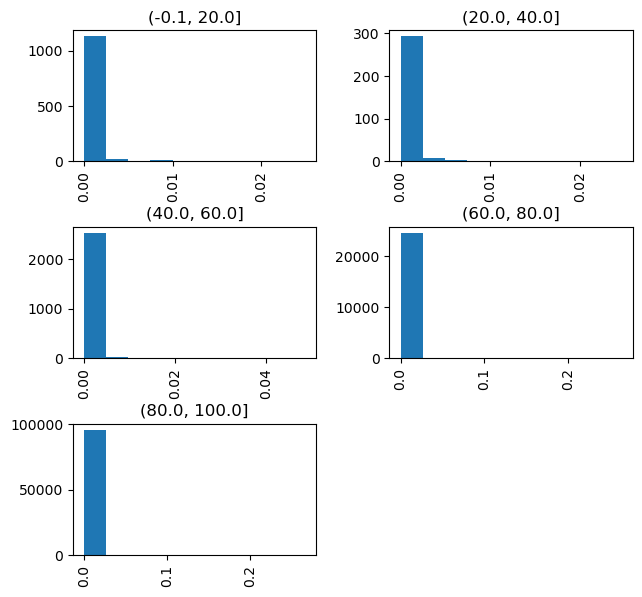

In [26]:
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
NG_df_recent['rts_per_followers'].hist(by=NG_df_recent['NG_score_bins'], ax=ax)

In [10]:
# compare this with complete dataset
NG_df["number_followers"] = NG_df["author.public_metrics.followers_count"]
NG_df["rts_per_followers"] = NG_df["number_rts"] / NG_df["number_followers"]
NG_df['NG_score_bins'] = pd.cut(NG_df['NG_score'], 5)
NG_grouped = NG_df.groupby('NG_score_bins', as_index=False)['rts_per_followers'].mean()

<AxesSubplot:xlabel='NG_score_bins'>

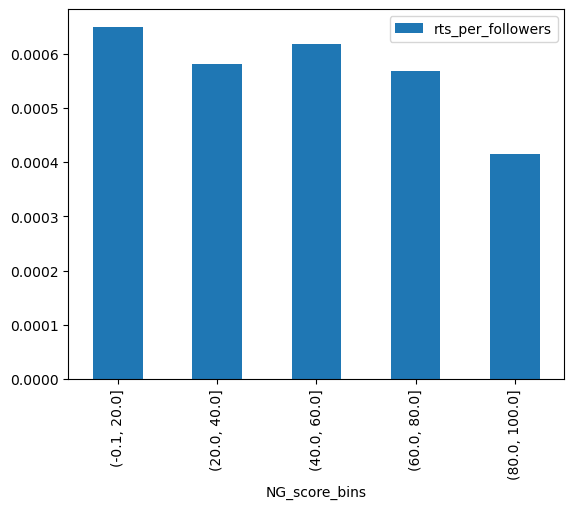

In [11]:
NG_grouped.plot(x="NG_score_bins", y="rts_per_followers", kind="bar")

We find that when normalizing the number of retweets per Tweet by the number of followers of the given politician, hereby only looking at years starting in 2021 (as follower number are currently not available historically), there is also a decreasing trend in number of retweets as the NG score increases.

Now look at relationship between average number of retweets per politician and their number of followers, again just for 2021-2023

In [35]:
NG_df_recent.columns

Index(['index', 'id', 'author_id', 'created_at',
       'referenced_tweets.retweeted.id', 'retweeted_user_id', 'text', 'lang',
       'source', 'public_metrics.retweet_count', 'public_metrics.quote_count',
       'public_metrics.reply_count', 'entities.hashtags', 'entities.urls',
       'author.username', 'author.name',
       'author.public_metrics.followers_count',
       'author.public_metrics.following_count',
       'author.public_metrics.tweet_count', 'retweeted', 'author_name',
       'Twitter_author_name', 'chamber', 'state_abbrev', 'bioname',
       'nominate_dim1', 'nominate_dim2', 'nominate_geo_mean_probability',
       'Congress', 'Party', 'Congress_Member_Name', 'Retweeted_author_party',
       'Retweeted_author_nominate_dim1', 'Democrat_retweets',
       'Republican_retweets', 'url', 'expanded_url', 'text_clean',
       'fixed_urls_final2', 'matched_NG_domain_new', 'matched_Ind_domain_new',
       'NG_score', 'NG_rating', 'Ind_acc', 'Ind_transp', 'Ind_type',
       'Numbe

In [36]:
NG_grouped_rts_recent = NG_df_recent.groupby('author_id', as_index=False)['number_rts'].mean()

In [42]:
NG_df_recent_followers = NG_df_recent.drop_duplicates(subset=['author_id'])

In [44]:
print(len(NG_df_recent_followers), len(NG_grouped_rts_recent))

790 790


In [106]:
NG_grouped_rts_recent = NG_df_recent.groupby('author_id', as_index=False).mean()

/tmp/ipykernel_17491/1308371458.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  NG_grouped_rts_recent = NG_df_recent.groupby('author_id', as_index=False).mean()


In [107]:
NG_grouped_rts_recent = NG_grouped_rts_recent[["author_id", "number_rts", "number_followers"]]

In [70]:
NG_grouped_rts_recent.iloc[0][2]

107755.0

In [68]:
NG_df_recent.dtypes

index                                      int64
id                                         int64
author_id                                  int64
created_at                        datetime64[ns]
referenced_tweets.retweeted.id            object
                                       ...      
number_rts                                 int64
Year                                       int64
number_followers                           int64
rts_per_followers                        float64
NG_score_bins                           category
Length: 65, dtype: object

In [69]:
# verifying that number of followers is the correct in the grouped df
for i in NG_df_recent.index:
    if NG_df_recent.at[i, 'author_id'] == 5558312:
            print(NG_df_recent.at[i, 'number_followers'])

107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755
107755


PearsonRResult(statistic=0.5620055909019468, pvalue=5.6515717280934814e-67)

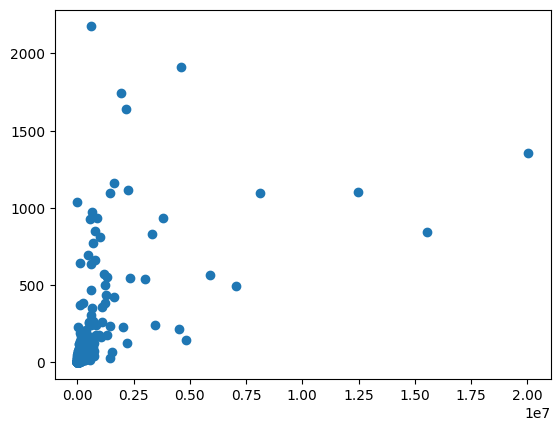

In [109]:
plt.scatter(NG_grouped_rts_recent["number_followers"], NG_grouped_rts_recent["number_rts"])
scipy.stats.pearsonr(NG_grouped_rts_recent["number_followers"], NG_grouped_rts_recent["number_rts"])

In [72]:
print(scipy.stats.pearsonr(NG_grouped_rts_recent["number_followers"], NG_grouped_rts_recent["number_rts"]))

PearsonRResult(statistic=0.5620055909019468, pvalue=5.6515717280934814e-67)


There is not a clear linear relationship between the number of a politician's followers and their average retweets. This means, the number of followers cannot explain well the average number of retweets the politician gets.
This helps because it means there are other variables explaining the number of retweets, for instance, the content of tweets, or politician's ideology, or even virality, where a politican with relatively few followers may get a lot of retweets on some tweets because the tweet went viral and reached lots of people who were not their direct followers.

Distribution of NewsGuard score per year

In [73]:
NG_grouped_year_recent = NG_df.groupby('Year', as_index=False)["NG_score"].mean()

<AxesSubplot:xlabel='Year'>

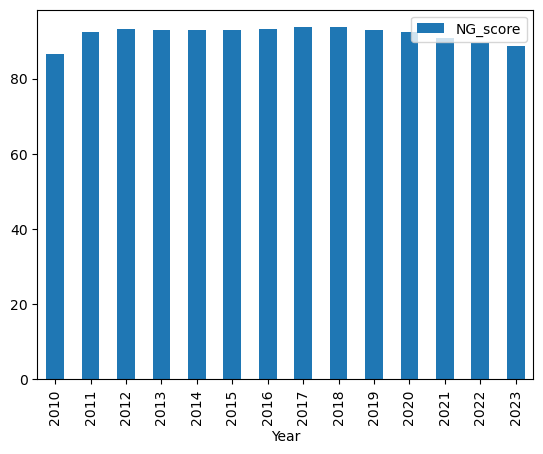

In [76]:
NG_grouped_year_recent.plot(x="Year", y="NG_score", kind="bar")

In [77]:
NG_grouped_year_recent

,Year,NG_score
0,2010,86.500000
1,2011,92.523842
2,2012,93.159153
3,2013,92.814105
4,2014,92.912315
5,2015,92.971683
6,2016,93.094539
7,2017,93.621097
8,2018,93.667934
9,2019,92.929565


We can see that the average posted link's NG Score stayed relatively constant around 92-93  until 2021, where it reduced to 90.7, and further reduced in 2022 to 89.5, and 88.5 in 2023. There are only slight reductions but could be related to the infodemic during COVID-19.

In [16]:
# now check if we have enough data to work with, if we only include the most recent years
print(len(NG_df_recent))
# in total, 199,787 observations
NG_df_recent['NG_score_bins'].value_counts()

124078


(80.0, 100.0]    95478
(60.0, 80.0]     24566
(40.0, 60.0]      2552
(-0.1, 20.0]      1174
(20.0, 40.0]       308
Name: NG_score_bins, dtype: int64

Annotations of sample of observations, first according to neutrality and from the sub-sample that is not neutral, annotate emotions, too.

In [80]:
print(len(data_OG))

541500


In [91]:
indx_lst = random.sample(list(range(541500)), 300)
data_sample = data_OG.iloc[indx_lst]
data_sample = data_sample[["index", "text", "Neutral_Sentiment", "Positive_Sentiment", "Negative_Sentiment", "Anger", "Fear", "Happiness", "Sadness", "Affection"]]
data_sample.to_csv("Data_Sample.csv")

In [103]:
data_sample.to_csv("Data_Sample.csv")

Conduct further analysis of Neutrality and Emotion annotation

In [404]:
data_sample_annotated = pd.read_csv(r"Sentiment_Emotion_Validation/Data_Sample.csv")

In [4]:
data_sample_annotated

,Unnamed: 0,index,text,Esther_Annotation,Neutral_Sentiment,Positive_Sentiment,Negative_Sentiment,Anger,Fear,Happiness,Sadness,Affection
0,241109,241309,Neighbors helping neighbors. That’s what our c...,Positive,0.033531,0.963919,0.002551,0.052062,0.039879,0.140377,0.032218,0.735465
1,128525,128570,The drugs that don’t kill Americans are making...,Negative,0.411985,0.041568,0.546447,0.312588,0.423851,0.029082,0.105790,0.128688
2,6010,6010,We've launched the #GA08 2018 Congressional Ap...,Neutral,0.333710,0.663783,0.002508,0.159957,0.095475,0.153080,0.030387,0.561101
3,508394,508998,As we continue to reckon with police violence ...,Negative,0.133346,0.860500,0.006153,0.339769,0.075548,0.051793,0.162102,0.370787
4,311358,311558,.@BristolCC's future National Offshore Wind In...,Positive,0.272830,0.722993,0.004177,0.051205,0.038626,0.513876,0.032729,0.363564
...,...,...,...,...,...,...,...,...,...,...,...,...
295,210965,211010,"On A-10 delay: ""This is the Admin's same ploy ...",Negative,0.238922,0.008762,0.752316,0.512299,0.304346,0.068334,0.042387,0.072634
296,321380,321580,President Biden's plan to revive the failed 20...,Negative,0.103244,0.005954,0.890803,0.736749,0.114961,0.032130,0.055739,0.060420
297,456748,456948,.@RepStefanik is also calling for a federal in...,Neutral,0.854004,0.060319,0.085676,0.246724,0.391909,0.144672,0.033997,0.182699
298,405194,405394,I joined other members of the Idaho delegation...,Neutral,0.691061,0.295062,0.013877,0.187021,0.128001,0.057582,0.084916,0.542480


In [132]:
pd.set_option('display.max_rows', 500)

In [405]:
NG_annotation = data_sample_annotated[(data_sample_annotated['Esther_Annotation'] == "Neutral")] 

<AxesSubplot: >

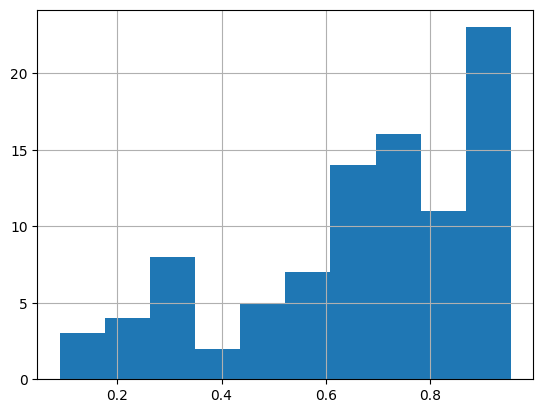

In [406]:
NG_annotation["Neutral_Sentiment"].hist()

In [410]:
# false negatives
NG_sentiment_nn["Esther_Annotation"].value_counts()

Negative    100
Positive     94
Neutral      28
Name: Esther_Annotation, dtype: int64

Analysis of annotation with emotion

In [150]:
indx_lst = random.sample(list(range(420353)), 200)
data_sample_emotion = data_no_neutral.iloc[indx_lst]
data_sample_emotion = data_sample_emotion[["index", "text", "Anger", "Fear", "Happiness", "Sadness", "Affection"]]
data_sample_emotion.to_csv("Data_Sample_Emotion.csv")

In [399]:
data_sample_annotated_emotion = pd.read_csv(r"Sentiment_Emotion_Validation/Data_Sample_Emotion.csv")

In [400]:
# before calculating F1 score for each emotion and then average this,
# first need to assign a hard label to the prediction
data_sample_annotated_emotion["Predicted_Annotation"] = None
count = 0
for i in data_sample_annotated_emotion.index:
    if (data_sample_annotated_emotion.at[i, 'Anger'] > data_sample_annotated_emotion.at[i, 'Happiness'] and data_sample_annotated_emotion.at[i, 'Anger'] > data_sample_annotated_emotion.at[i, 'Fear'] and data_sample_annotated_emotion.at[i, 'Anger'] > data_sample_annotated_emotion.at[i, 'Sadness'] and data_sample_annotated_emotion.at[i, 'Anger'] > data_sample_annotated_emotion.at[i, 'Affection']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "anger"
    elif (data_sample_annotated_emotion.at[i, 'Happiness'] > data_sample_annotated_emotion.at[i, 'Anger'] and data_sample_annotated_emotion.at[i, 'Happiness'] > data_sample_annotated_emotion.at[i, 'Fear'] and data_sample_annotated_emotion.at[i, 'Happiness'] > data_sample_annotated_emotion.at[i, 'Sadness'] and data_sample_annotated_emotion.at[i, 'Happiness'] > data_sample_annotated_emotion.at[i, 'Affection']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "happiness"
    elif (data_sample_annotated_emotion.at[i, 'Sadness'] > data_sample_annotated_emotion.at[i, 'Anger'] and data_sample_annotated_emotion.at[i, 'Sadness'] > data_sample_annotated_emotion.at[i, 'Fear'] and data_sample_annotated_emotion.at[i, 'Sadness'] > data_sample_annotated_emotion.at[i, 'Happiness'] and data_sample_annotated_emotion.at[i, 'Sadness'] > data_sample_annotated_emotion.at[i, 'Affection']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "sadness"
    elif (data_sample_annotated_emotion.at[i, 'Fear'] > data_sample_annotated_emotion.at[i, 'Anger'] and data_sample_annotated_emotion.at[i, 'Fear'] > data_sample_annotated_emotion.at[i, 'Sadness'] and data_sample_annotated_emotion.at[i, 'Fear'] > data_sample_annotated_emotion.at[i, 'Happiness'] and data_sample_annotated_emotion.at[i, 'Fear'] > data_sample_annotated_emotion.at[i, 'Affection']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "fear"
    elif (data_sample_annotated_emotion.at[i, 'Affection'] > data_sample_annotated_emotion.at[i, 'Anger'] and data_sample_annotated_emotion.at[i, 'Affection'] > data_sample_annotated_emotion.at[i, 'Sadness'] and data_sample_annotated_emotion.at[i, 'Affection'] > data_sample_annotated_emotion.at[i, 'Happiness'] and data_sample_annotated_emotion.at[i, 'Affection'] > data_sample_annotated_emotion.at[i, 'Fear']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "affection"
    else:
        count+=1
        
print(count)

0


In [157]:
data_sample_annotated_emotion

,Unnamed: 0,index,text,Esther_Annotation,Anger,Fear,Happiness,Sadness,Affection,Predicted_Annotation
0,506277,506881,Reports that extremist groups are infiltrating...,fear,0.172979,0.628900,0.027999,0.039580,0.130542,fear
1,303642,303842,"This week, I successfully fought to protect fe...",affection,0.112499,0.065819,0.100031,0.038511,0.683141,affection
2,86865,86865,I reintroduced the California Central Coast Co...,affection,0.080320,0.066582,0.254897,0.028946,0.569255,affection
3,23924,23924,"Today, I voted in favor of #DCStatehood for th...",affection,0.084705,0.069461,0.100200,0.039213,0.706422,affection
4,372205,372405,"@realDonaldTrump, have you considered joining ...",affection,0.090821,0.075294,0.096908,0.048399,0.688577,affection
5,232859,233059,.@Google bans @FDRLST from its ad platform for...,anger,0.752050,0.057741,0.049520,0.086683,0.054007,anger
6,504469,505073,People need help now—this is not a time for in...,affection,0.222912,0.292458,0.033127,0.084426,0.367076,affection
7,358669,358869,Telehealth is a significant way to expand acce...,affection,0.067318,0.100292,0.065209,0.040554,0.726626,affection
8,77187,77187,I have been leading the effort to end Kathy Ho...,affection,0.238263,0.074102,0.190441,0.028757,0.468438,affection
9,357296,357496,Good news for MN businesses: UK plans to open ...,happiness,0.049965,0.037983,0.747273,0.036855,0.127925,happiness


In [401]:
# calculate F1 score between prediction (LEIA) and ground truth (my annotations)
# use macro measure because labels are rather imbalanced and that should be considered in the F1 calculation

F1_emotion = f1_score(data_sample_annotated_emotion["Esther_Annotation"], data_sample_annotated_emotion["Predicted_Annotation"], average='macro')

In [402]:
print(F1_emotion)

0.7683426028921023


We get an F1 score of 76.8%, which is relatively high.

Plot ROC curve across different thresholds for neutrality

In [424]:
data_sample_annotated["Neutral_th1"] = data_sample_annotated['Neutral_Sentiment'] > 0.60

In [425]:
data_sample_annotated["Neutral_gt"] =  data_sample_annotated['Esther_Annotation'] == "Neutral"

In [426]:
# check balance of categories for both ground truth and predicted label
data_sample_annotated['Neutral_th1'].value_counts()

False    222
True      78
Name: Neutral_th1, dtype: int64

In [427]:
data_sample_annotated['Neutral_gt'].value_counts()

False    207
True      93
Name: Neutral_gt, dtype: int64

We can see that the classes are relatively imbalanced, so we should use a micro average.

In [24]:
data_sample_annotated

,Unnamed: 0,index,text,Esther_Annotation,Neutral_Sentiment,Positive_Sentiment,Negative_Sentiment,Anger,Fear,Happiness,Sadness,Affection,Neutral_th1,Neutral_gt,Neutral_gt_int
0,241109,241309,Neighbors helping neighbors. That’s what our c...,Positive,0.033531,0.963919,0.002551,0.052062,0.039879,0.140377,0.032218,0.735465,False,False,0
1,128525,128570,The drugs that don’t kill Americans are making...,Negative,0.411985,0.041568,0.546447,0.312588,0.423851,0.029082,0.105790,0.128688,False,False,0
2,6010,6010,We've launched the #GA08 2018 Congressional Ap...,Neutral,0.333710,0.663783,0.002508,0.159957,0.095475,0.153080,0.030387,0.561101,False,True,1
3,508394,508998,As we continue to reckon with police violence ...,Negative,0.133346,0.860500,0.006153,0.339769,0.075548,0.051793,0.162102,0.370787,False,False,0
4,311358,311558,.@BristolCC's future National Offshore Wind In...,Positive,0.272830,0.722993,0.004177,0.051205,0.038626,0.513876,0.032729,0.363564,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,210965,211010,"On A-10 delay: ""This is the Admin's same ploy ...",Negative,0.238922,0.008762,0.752316,0.512299,0.304346,0.068334,0.042387,0.072634,False,False,0
296,321380,321580,President Biden's plan to revive the failed 20...,Negative,0.103244,0.005954,0.890803,0.736749,0.114961,0.032130,0.055739,0.060420,False,False,0
297,456748,456948,.@RepStefanik is also calling for a federal in...,Neutral,0.854004,0.060319,0.085676,0.246724,0.391909,0.144672,0.033997,0.182699,True,True,1
298,405194,405394,I joined other members of the Idaho delegation...,Neutral,0.691061,0.295062,0.013877,0.187021,0.128001,0.057582,0.084916,0.542480,True,True,1


Do ROC curve and Precision-Recall curve
* https://www.kaggle.com/code/nicholasgah/optimal-probability-thresholds-using-pr-curve

In [428]:
data_sample_annotated["Neutral_gt_int"] = data_sample_annotated["Neutral_gt"].astype(int)

In [429]:
# compute ROC curve
# take labels of ground truth and probabilities of predicted label
neutral_prob = data_sample_annotated["Neutral_Sentiment"].values.tolist()
neutral_labels = data_sample_annotated["Neutral_gt_int"].values.tolist()

In [430]:
from sklearn import metrics

In [431]:
fpr, tpr, thresholds = metrics.roc_curve(neutral_labels, neutral_prob)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [432]:
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.551735, G-Mean=0.836


In [433]:
# calculate AUC (area under curve)
auc = metrics.roc_auc_score(neutral_labels, neutral_prob)
print('AUC: %.3f' % auc)

AUC: 0.909


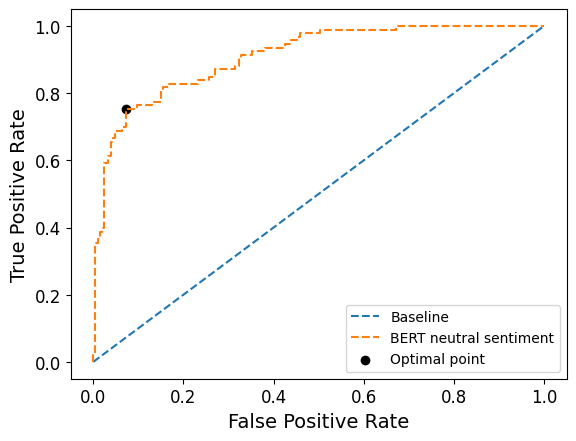

In [437]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Baseline')
plt.plot(fpr, tpr, linestyle='--', label='BERT neutral sentiment')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Optimal point')

# axis labels
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)


# Set tick labels font size
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)


# show the legend
plt.legend()
# Save the figure as a vectorized image (SVG format)
plt.savefig('ROC_Curve_Neutral.svg', format='svg')

# Display the plot
plt.show()


Choosing the best threshold, i.e., the operating point
* http://www0.cs.ucl.ac.uk/staff/W.Langdon/roc/
* The best operating point might be chosen so that the classifier gives the best trade off between the costs of failing to detect positives against the costs of raising false alarms. These costs need not be equal, however this is a common assumption. 

In [50]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.5517351


Precision-Recall Curve

AUC=0.826


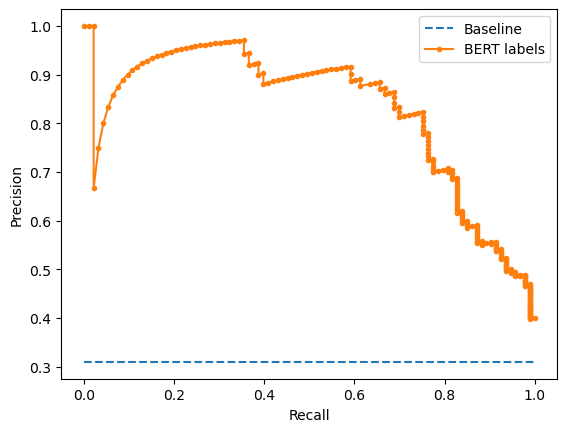

In [40]:
# we also look at the precision-recall curve, which is recommended when there is a moderate to large imbalance of classes
precision, recall, thresholds = metrics.precision_recall_curve(neutral_labels, neutral_prob)
auc = metrics.auc(recall, precision)
# summarize scores
print('AUC=%.3f' % (auc))
# plot the precision-recall curves
baseline = neutral_labels.count(1) / len(neutral_labels)
plt.plot([0, 1], [baseline, baseline], linestyle="--", label='Baseline')
plt.plot(recall, precision, marker='.', label='BERT labels')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [43]:
# use F1 score for each threshold to get best threshold
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.551735, F-Score=0.787


In [61]:
optimal_proba_cutoff = 0.551735
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in neutral_prob]
predictions = [1 if i >= 0.5 else 0 for i in neutral_prob]

In [62]:

print("Accuracy Score Before and After Thresholding: {}, {}".format(metrics.accuracy_score(neutral_labels, predictions), metrics.accuracy_score(neutral_labels, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(metrics.precision_score(neutral_labels, predictions), metrics.precision_score(neutral_labels, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(metrics.recall_score(neutral_labels, predictions), metrics.recall_score(neutral_labels, roc_predictions)))
print("F1 Score Before and After Thresholding: {}, {}".format(metrics.f1_score(neutral_labels, predictions), metrics.f1_score(neutral_labels, roc_predictions)))


Accuracy Score Before and After Thresholding: 0.84, 0.8733333333333333
Precision Score Before and After Thresholding: 0.7272727272727273, 0.8235294117647058
Recall Score Before and After Thresholding: 0.7741935483870968, 0.7526881720430108
F1 Score Before and After Thresholding: 0.7500000000000001, 0.7865168539325843


In [63]:
# confusion matrix before thresholding
y_actual = pd.Series(neutral_labels, name='Actual')
y_predict_tf = pd.Series(predictions, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predict_tf, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)

Predicted    0   1  All
Actual                 
0          180  27  207
1           21  72   93
All        201  99  300


In [64]:
# confusion matrix after thresholding
y_actual = pd.Series(neutral_labels, name='Actual')
y_predict_tf = pd.Series(roc_predictions, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predict_tf, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

Predicted    0   1  All
Actual                 
0          192  15  207
1           23  70   93
All        215  85  300


Now we got our optimal threshold, which according to both the ROC curve and the Precision-Recall curve, is at 0.5517.
Thus, we can remove observations with a predicted neutrality score exceeding this value and then analyse emotions.

In [51]:
# remove observations with neutral score above this threshold
data_no_neutral = data_sample_annotated[(data_sample_annotated['Neutral_Sentiment'] <= 0.551735)] 

In [52]:
data_no_neutral
# after removing observations according to the optimal threshold, we have 215 out of 300 observations left

,Unnamed: 0,index,text,Esther_Annotation,Neutral_Sentiment,Positive_Sentiment,Negative_Sentiment,Anger,Fear,Happiness,Sadness,Affection,Neutral_th1,Neutral_gt,Neutral_gt_int
0,241109,241309,Neighbors helping neighbors. That’s what our c...,Positive,0.033531,0.963919,0.002551,0.052062,0.039879,0.140377,0.032218,0.735465,False,False,0
1,128525,128570,The drugs that don’t kill Americans are making...,Negative,0.411985,0.041568,0.546447,0.312588,0.423851,0.029082,0.105790,0.128688,False,False,0
2,6010,6010,We've launched the #GA08 2018 Congressional Ap...,Neutral,0.333710,0.663783,0.002508,0.159957,0.095475,0.153080,0.030387,0.561101,False,True,1
3,508394,508998,As we continue to reckon with police violence ...,Negative,0.133346,0.860500,0.006153,0.339769,0.075548,0.051793,0.162102,0.370787,False,False,0
4,311358,311558,.@BristolCC's future National Offshore Wind In...,Positive,0.272830,0.722993,0.004177,0.051205,0.038626,0.513876,0.032729,0.363564,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,169160,169205,Don't ever let anyone tell you what @TheDemocr...,Positive,0.266531,0.687060,0.046409,0.228063,0.103401,0.157279,0.031130,0.480128,False,False,0
291,214877,214922,Congrats to @CityofRacine for winning the Smar...,Positive,0.014499,0.983061,0.002440,0.057121,0.030428,0.598988,0.033118,0.280345,False,False,0
294,479773,479973,"I join millions of people in Israel, the US, &...",Negative,0.518897,0.043607,0.437496,0.045373,0.038002,0.030843,0.755864,0.129918,False,False,0
295,210965,211010,"On A-10 delay: ""This is the Admin's same ploy ...",Negative,0.238922,0.008762,0.752316,0.512299,0.304346,0.068334,0.042387,0.072634,False,False,0


In [75]:
data_no_neutral.to_csv(r"C:\Users\Simmendinger\OneDrive - bwedu\Dokumente\Konstanz SEDS Data\4. Semester\Master Thesis\Methods\Sentiment_Emotion_Annotation\Data_Sample_Emotion_20230605.csv")

In [81]:
# use new emotion annotated sample for the evaluation
# F1 scores and confusion matrices
data_sample_annotated_emotion = pd.read_csv(r"C:\Users\Simmendinger\OneDrive - bwedu\Dokumente\Konstanz SEDS Data\4. Semester\Master Thesis\Methods\Sentiment_Emotion_Annotation\Data_Sample_Emotion_20230605.csv")

In [85]:
data_sample_annotated_emotion["Predicted_Annotation"] = None
count = 0
for i in data_sample_annotated_emotion.index:
    if (data_sample_annotated_emotion.at[i, 'Anger'] > data_sample_annotated_emotion.at[i, 'Happiness'] and data_sample_annotated_emotion.at[i, 'Anger'] > data_sample_annotated_emotion.at[i, 'Fear'] and data_sample_annotated_emotion.at[i, 'Anger'] > data_sample_annotated_emotion.at[i, 'Sadness'] and data_sample_annotated_emotion.at[i, 'Anger'] > data_sample_annotated_emotion.at[i, 'Affection']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "Anger"
    elif (data_sample_annotated_emotion.at[i, 'Happiness'] > data_sample_annotated_emotion.at[i, 'Anger'] and data_sample_annotated_emotion.at[i, 'Happiness'] > data_sample_annotated_emotion.at[i, 'Fear'] and data_sample_annotated_emotion.at[i, 'Happiness'] > data_sample_annotated_emotion.at[i, 'Sadness'] and data_sample_annotated_emotion.at[i, 'Happiness'] > data_sample_annotated_emotion.at[i, 'Affection']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "Happiness"
    elif (data_sample_annotated_emotion.at[i, 'Sadness'] > data_sample_annotated_emotion.at[i, 'Anger'] and data_sample_annotated_emotion.at[i, 'Sadness'] > data_sample_annotated_emotion.at[i, 'Fear'] and data_sample_annotated_emotion.at[i, 'Sadness'] > data_sample_annotated_emotion.at[i, 'Happiness'] and data_sample_annotated_emotion.at[i, 'Sadness'] > data_sample_annotated_emotion.at[i, 'Affection']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "Sadness"
    elif (data_sample_annotated_emotion.at[i, 'Fear'] > data_sample_annotated_emotion.at[i, 'Anger'] and data_sample_annotated_emotion.at[i, 'Fear'] > data_sample_annotated_emotion.at[i, 'Sadness'] and data_sample_annotated_emotion.at[i, 'Fear'] > data_sample_annotated_emotion.at[i, 'Happiness'] and data_sample_annotated_emotion.at[i, 'Fear'] > data_sample_annotated_emotion.at[i, 'Affection']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "Fear"
    elif (data_sample_annotated_emotion.at[i, 'Affection'] > data_sample_annotated_emotion.at[i, 'Anger'] and data_sample_annotated_emotion.at[i, 'Affection'] > data_sample_annotated_emotion.at[i, 'Sadness'] and data_sample_annotated_emotion.at[i, 'Affection'] > data_sample_annotated_emotion.at[i, 'Happiness'] and data_sample_annotated_emotion.at[i, 'Affection'] > data_sample_annotated_emotion.at[i, 'Fear']):
            data_sample_annotated_emotion.at[i, 'Predicted_Annotation'] = "Affection"
    else:
        count+=1
        
print(count)

0


In [86]:
F1_emotion = f1_score(data_sample_annotated_emotion["Emotion_Esther"], data_sample_annotated_emotion["Predicted_Annotation"], average='macro')

In [73]:
print(F1_emotion)

0.6351897031607178


In [87]:
y_true = data_sample_annotated_emotion["Emotion_Esther"].values.tolist()
y_pred = data_sample_annotated_emotion["Predicted_Annotation"].values.tolist()

The overall F1 score for predicted vs. annotated emotion is 63.52%.

In [89]:
# confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred, labels=["Anger", "Fear", "Sadness", "Happiness", "Affection"])

array([[[131,   6],
        [ 12,  66]],

       [[183,  12],
        [  8,  12]],

       [[207,   2],
        [  1,   5]],

       [[171,  14],
        [  5,  25]],

       [[125,   9],
        [ 17,  64]]], dtype=int64)

In [91]:
# descriptives of LEIA emotion labels in sample
data_sample_annotated_emotion['Predicted_Annotation'].value_counts()

Affection    73
Anger        72
Happiness    39
Fear         24
Sadness       7
Name: Predicted_Annotation, dtype: int64

In [97]:
data_sample_annotated_emotion["Affection"].mean()

0.29557504158604647

# Retweet analysis

In [318]:
# Opening JSON file
f = open(r'Final_Data_20230508.json')
  
# returns JSON object as 
# a dictionary
data = pd.read_json(f)
  
# Closing file
f.close()

In [326]:
data_OG = data[data["retweeted_user_id"] == "None"]

In [327]:
data_OG["retweet_count"] = data_OG["public_metrics.retweet_count"]

/tmp/ipykernel_17491/2330204149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OG["retweet_count"] = data_OG["public_metrics.retweet_count"]


In [328]:
retweet_count = data_OG["retweet_count"].values.tolist()


In [334]:
retweet_count_log = np.log(retweet_count_incr)

(array([4.9166e+04, 0.0000e+00, 0.0000e+00, 6.3914e+04, 5.5571e+04,
        0.0000e+00, 4.4357e+04, 3.4358e+04, 4.8128e+04, 3.1656e+04,
        2.1869e+04, 2.2797e+04, 1.6386e+04, 1.9446e+04, 1.3915e+04,
        1.4085e+04, 1.3291e+04, 1.1518e+04, 9.7030e+03, 9.0740e+03,
        7.8820e+03, 7.1740e+03, 6.2590e+03, 5.5050e+03, 4.7000e+03,
        4.5190e+03, 3.9270e+03, 3.4310e+03, 3.0890e+03, 2.7080e+03,
        2.4410e+03, 2.1180e+03, 1.7430e+03, 1.5430e+03, 1.2920e+03,
        1.0560e+03, 8.6400e+02, 6.2400e+02, 4.3800e+02, 3.7500e+02,
        2.4200e+02, 1.4800e+02, 9.4000e+01, 4.9000e+01, 2.3000e+01,
        1.1000e+01, 6.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 0.        ,  0.22162869,  0.44325738,  0.66488608,  0.88651477,
         1.10814346,  1.32977215,  1.55140084,  1.77302954,  1.99465823,
         2.21628692,  2.43791561,  2.65954431,  2.881173  ,  3.10280169,
         3.32443038,  3.54605907,  3.76768777,  3.98931646,  4.21094515,
         4.43257384,  4.65

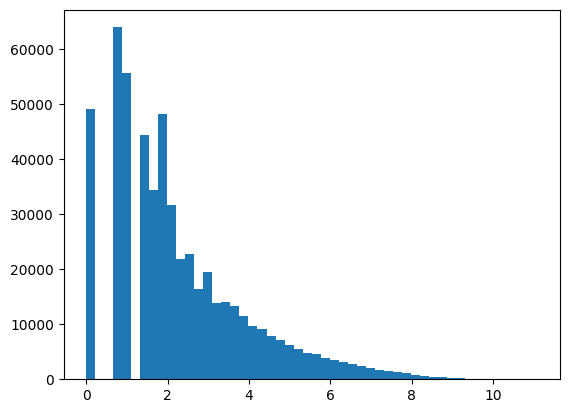

In [338]:
plt.hist(retweet_count_log, bins=50)

In [18]:
count = 0
for item in retweet_count:
    if item <10:
        count+=1
        
print(count/len(retweet_count))

0.6260147737765467


In [19]:
count = 0
for item in retweet_count:
    if item >100:
        count+=1
        
print(count/len(retweet_count))

0.10296029547553093


In [20]:
count = 0
for item in retweet_count:
    if item >1000:
        count+=1
        
print(count/len(retweet_count))

0.018936288088642658


62.6% of all tweets were retweeted less than 10 times, 10.3% of tweets were retweeted over 100 times and 1.9% were retweeted over 1,000 times, indicating some exponential pattern and preferential attachment feature.

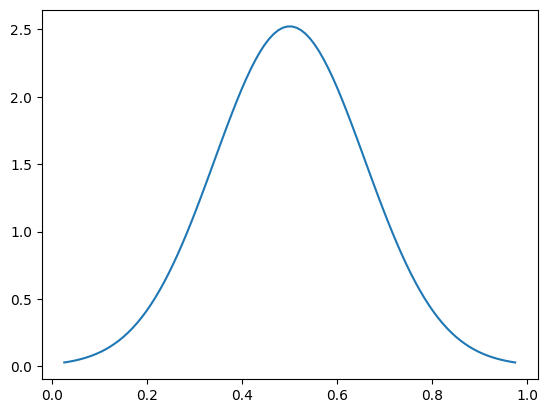

In [26]:
mu = 0.5
variance = 0.025
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [27]:
print(x.max())

0.9743416490252569


Now we look at retweets per follower count of politicians. For this, we only look at data starting in 2021.

In [11]:

data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]
NG_df = data_OG[(data_OG['NG_score'] != "None") & (data_OG['NG_score'] != "none") & (data_OG['NG_score'] != None) & (data_OG['NG_score'].isna() != True)] 
# make deciles of the NG Score
NG_df = NG_df[NG_df["NG_score"] <= 100]
NG_df["Year"] = NG_df["created_at"].dt.year
# make a df with only observations of 2021-2023
NG_df_recent = NG_df[(NG_df['Year'] >= 2021)] 
NG_df_recent["number_followers"] = NG_df_recent["author.public_metrics.followers_count"]
NG_df_recent["rts_per_followers"] = NG_df_recent["number_rts"] / NG_df_recent["number_followers"]
NG_df_recent['NG_score_bins'] = pd.cut(NG_df_recent['NG_score'], 5)
NG_df_recent["number_rts_log"] = np.log(NG_df_recent["number_rts"]+1)
NG_grouped_recent = NG_df_recent.groupby('NG_score_bins', as_index=False)['number_rts_log'].mean()

/tmp/ipykernel_66354/2987315615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OG["number_rts"] = data_OG["public_metrics.retweet_count"]
/tmp/ipykernel_66354/2987315615.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NG_df_recent["number_followers"] = NG_df_recent["author.public_metrics.followers_count"]
/tmp/ipykernel_66354/2987315615.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [139]:
NG_grouped_recent

,NG_score_bins,number_rts_log
0,"(-0.1, 20.0]",2.983225
1,"(20.0, 40.0]",3.041819
2,"(40.0, 60.0]",3.135476
3,"(60.0, 80.0]",2.703382
4,"(80.0, 100.0]",2.453822


In [340]:

NG_df["number_followers"] = NG_df["author.public_metrics.followers_count"]
NG_df["number_followers_log"] = np.log(NG_df["author.public_metrics.followers_count"]+1)
NG_df["number_rts_log"] = np.log(NG_df["number_rts"]+1)
NG_df["rts_per_followers_log"] = NG_df["number_rts_log"] / NG_df["number_followers_log"]
NG_df['NG_score_bins'] = pd.cut(NG_df['NG_score'], 5)

In [118]:
NG_grouped_log = NG_df.groupby('NG_score_bins', as_index=False)['number_rts_log'].mean()

<AxesSubplot: xlabel='NG_score_bins'>

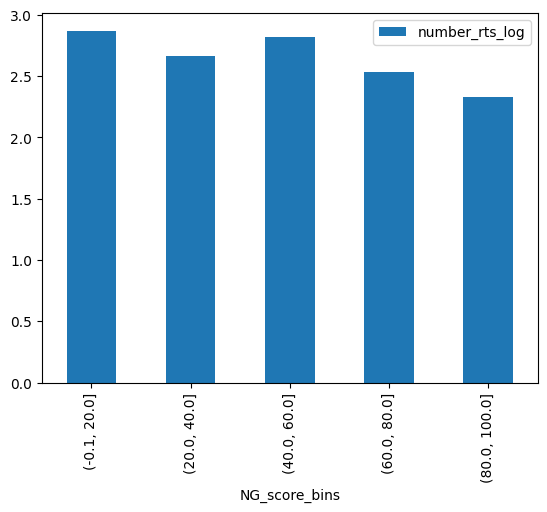

In [119]:
NG_grouped_log.plot(x="NG_score_bins", y="number_rts_log", kind="bar")

In [180]:
# follower count get distribution
follower_count = data_OG["author.public_metrics.followers_count"].values.tolist()

In [174]:
follower_count_log = NG_df["number_followers_log"].values.tolist()

In [389]:
groups = NG_df.groupby('author_id', as_index=False)['number_followers_log'].mean()

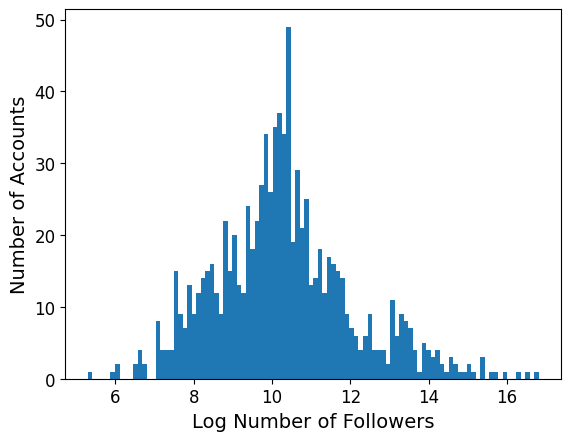

In [395]:
#sns.kdeplot(NG_df["number_followers_log"],fill=True, color='blue', alpha=0.5)
# Group the data by "author_id" and plot histograms for each group

plt.hist(groups["number_followers_log"], bins=100,  label=author)

# Set x-axis label with increased font size
plt.xlabel('Log Number of Followers', fontsize=14)

# Set y-axis label with increased font size
plt.ylabel('Number of Accounts', fontsize=14)

# Set tick labels font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the figure as a vectorized image (SVG format)
plt.savefig('ABM_Files/Final_Model_Code_Data/Figures/descriptives_logfoll_acrossaccounts.svg', format='svg')
# Display the plot
plt.show()

In [365]:
NG_df_recent['number_rts_log'] = np.log(NG_df_recent['number_rts']+1)
NG_df_recent['number_followers_log'] = np.log(NG_df_recent['number_followers']+1)

/tmp/ipykernel_17491/4098065961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NG_df_recent['number_rts_log'] = np.log(NG_df_recent['number_rts']+1)
/tmp/ipykernel_17491/4098065961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NG_df_recent['number_followers_log'] = np.log(NG_df_recent['number_followers']+1)


In [154]:
NG_df_recent['rts_per_followers_log'] = NG_df_recent["number_rts_log"] / NG_df_recent["number_followers_log"]

/tmp/ipykernel_17491/4086728872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NG_df_recent['rts_per_followers_log'] = NG_df_recent["number_rts_log"] / NG_df_recent["number_followers_log"]


<AxesSubplot: >

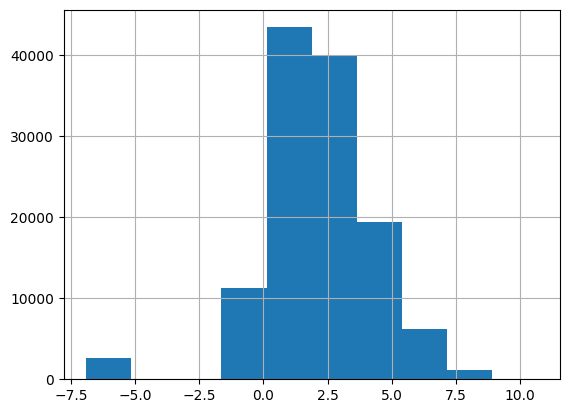

In [363]:
NG_df_recent['number_rts_log'].hist()

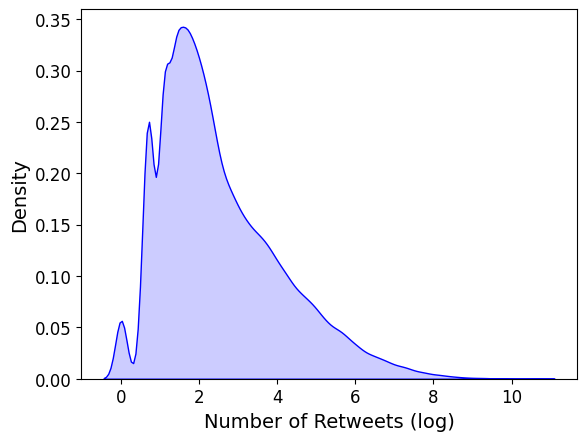

In [13]:
#NG_df_recent['number_rts_log'].plot.hist(bins = 50)
import seaborn as sns
# Plot kernel density curve using seaborn
sns.kdeplot(NG_df_recent['number_rts_log'], fill=True, color='b', alpha=0.2)

# Set x-axis label with increased font size
plt.xlabel('Number of Retweets (log)', fontsize=14)

# Set y-axis label with increased font size
plt.ylabel('Density', fontsize=14)

# Set tick labels font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('ABM_Files/Final_Model_Code_Data/Figures/descriptives_rtcount_log_kde.svg', format='svg')
# Display the plot
plt.show()


Network analysis

In [255]:
pol_network_merged = pd.read_csv("ABM_Files/Final_Model_Code_Data/pol_network_merged.csv")
pol_follower_partisanship = pd.read_csv("ABM_Files/Final_Model_Code_Data/Politicians_Followers_Estimated_Partisanship_20230710.csv")
pol_network_dict = pol_network_merged.to_dict(orient='records')

In [256]:
pol_network_df = pd.DataFrame(pol_network_dict)
pol_follower_partisanship = pol_follower_partisanship.rename(columns = {"politician_id": "Politician_ID"})
pol_network_df_merged = pd.merge(pol_network_df, pol_follower_partisanship, on ="Politician_ID", how = "left")
pol_network_df_merged["DemocratShare"] = pol_network_df_merged["DemocratCount"]/pol_network_df_merged["Follower_count"]
pol_network_df_merged["RepublicanShare"] = pol_network_df_merged["RepublicanCount"]/pol_network_df_merged["Follower_count"]
pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Democrat', 'SamePartyShare'] = pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Democrat', 'DemocratShare']
pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Republican', 'SamePartyShare'] = pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Republican', 'RepublicanShare']
pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Democrat', 'OppPartyShare'] = pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Democrat', 'RepublicanShare']
pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Republican', 'OppPartyShare'] = pol_network_df_merged.loc[pol_network_df_merged['Party'] == 'Republican', 'DemocratShare']

pol_network_df_merged['NoPartyShare'] = 1 - pol_network_df_merged['SamePartyShare'] - pol_network_df_merged['OppPartyShare']

pol_network_dict = pol_network_df_merged.to_dict(orient='records')

In [257]:
pol_network_df_merged_Foll_count = pol_network_df_merged[["Politician_ID", "Follower_count", "SamePartyShare"]]
pol_network_df_merged_Foll_count = pol_network_df_merged_Foll_count.rename(columns = {"Politician_ID": "author_id_new"})
NG_df_recent_merged = pd.merge(NG_df_recent, pol_network_df_merged_Foll_count, on="author_id_new", how="left")
NG_df_recent = NG_df_recent_merged

In [295]:
NG_df_recent = pd.read_csv("ABM_Files/Final_Model_Code_Data/NG_df_recent_ABM_Public.csv")

In [ ]:
# correlation between politician follower count and DW-NOMINATE score

In [309]:
NG_df_recent_Dem= NG_df_recent[NG_df_recent["nominate_dim1"]<0]
NG_df_recent_Rep= NG_df_recent[NG_df_recent["nominate_dim1"]>0]

In [313]:
from scipy.stats import pearsonr


correlation, p_value = pearsonr(NG_df_recent_Rep["author.public_metrics.followers_count"], NG_df_recent_Rep["nominate_dim1"])

print("Correlation:", correlation)
print("P-value:", p_value)

Correlation: 0.23012046432073188
P-value: 0.0
